In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller, kpss, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 6)

# Load data
df = pd.read_excel('result_hack_filtrado_con_peso_precioA.xlsx')

# Get list of unique product IDs
product_ids = sorted(df['ITEMCODE'].unique())
print(f"Product IDs to analyze: {product_ids}")
print(f"Total products: {len(product_ids)}")

# Function to aggregate data by product and date
def prepare_time_series(df, itemcode, freq='D'):
    """
    Aggregate sales data for a specific product

    Parameters:
    - df: Original dataframe
    - itemcode: Product ID to filter
    - freq: Frequency for aggregation ('D'=daily, 'W'=weekly, 'M'=monthly)

    Returns:
    - Time series dataframe with datetime index
    """
    # Filter by product
    product_df = df[df['ITEMCODE'] == itemcode].copy()

    # Aggregate by date
    ts_df = product_df.groupby('FECHA').agg({
        'SALES': 'sum',
        'PASSENGERS': 'sum',
        'LOSTSALES': 'sum'
    }).reset_index()

    # Rename columns
    ts_df.columns = ['Periodo', 'Ventas', 'Pasajeros', 'Ventas_Perdidas']

    # Set date as index
    ts_df['Periodo'] = pd.to_datetime(ts_df['Periodo'])
    ts_df = ts_df.set_index('Periodo')

    # Resample to ensure all dates are present (fill missing with 0)
    ts_df = ts_df.asfreq(freq, fill_value=0)

    return ts_df

# Example: Prepare time series for first product (daily aggregation)
itemcode_example = product_ids[0]
data_og = prepare_time_series(df, itemcode_example, freq='D')

print(f"\n\nTime series for Product {itemcode_example}:")
print(f"Shape: {data_og.shape}")
print(f"Date range: {data_og.index.min()} to {data_og.index.max()}")
print(f"Total days: {len(data_og)}")
print("\nFirst 10 observations:")
print(data_og.head(10))
print("\nBasic statistics:")
print(data_og.describe())

Product IDs to analyze: [np.int64(4542), np.int64(4561), np.int64(4568), np.int64(4602), np.int64(4675), np.int64(4692), np.int64(4702), np.int64(4722), np.int64(4728), np.int64(4729)]
Total products: 10


Time series for Product 4542:
Shape: (242, 3)
Date range: 2025-01-01 00:00:00 to 2025-08-30 00:00:00
Total days: 242

First 10 observations:
            Ventas  Pasajeros  Ventas_Perdidas
Periodo                                       
2025-01-01     115      10401               31
2025-01-02     178      16422               89
2025-01-03     168      15868               49
2025-01-04     151      15718               39
2025-01-05     198      18607              103
2025-01-06     177      15700               97
2025-01-07     146      12148               72
2025-01-08     156      11582               30
2025-01-09     157      11436              113
2025-01-10     187      14234               55

Basic statistics:
           Ventas     Pasajeros  Ventas_Perdidas
count  242.000000    

=== ANÁLISIS DE SERIE DE TIEMPO - PRODUCTO 4542 ===



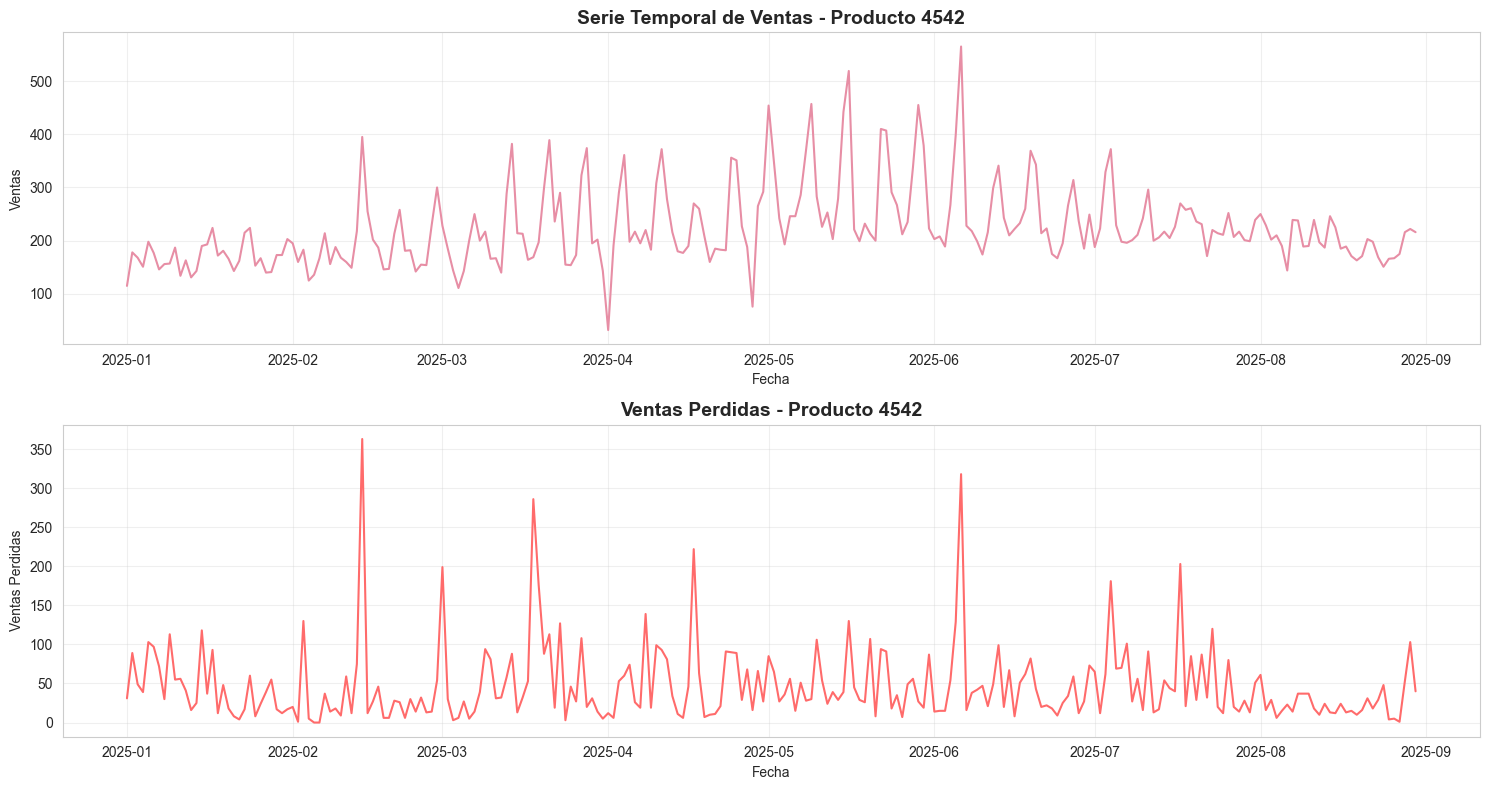


=== ESTADÍSTICAS DESCRIPTIVAS ===
           Ventas  Ventas_Perdidas
count  242.000000       242.000000
mean   223.619835        47.157025
std     75.354846        49.635269
min     32.000000         0.000000
25%    175.500000        16.000000
50%    206.500000        30.500000
75%    246.000000        60.750000
max    565.000000       363.000000

=== VALORES FALTANTES ===
Ventas             0
Pasajeros          0
Ventas_Perdidas    0
dtype: int64


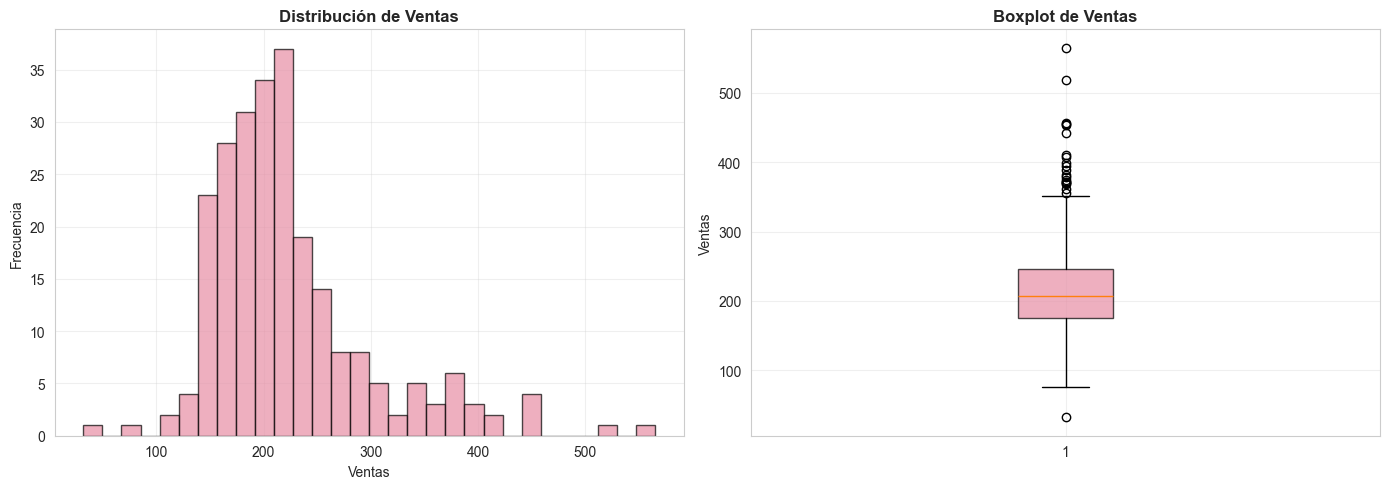

In [3]:
# Select product to analyze
PRODUCT_ID = product_ids[0]  # Change index to analyze different products
data_og = prepare_time_series(df, PRODUCT_ID, freq='D')

# Reset index for plotting
data_plot = data_og.reset_index()

print(f"=== ANÁLISIS DE SERIE DE TIEMPO - PRODUCTO {PRODUCT_ID} ===\n")

# 1.1 Visualización de la serie temporal
fig, axes = plt.subplots(2, 1, figsize=(15, 8))

# Plot Ventas
axes[0].plot(data_plot['Periodo'], data_plot['Ventas'],
             color='#e78ea5', linewidth=1.5)
axes[0].set_title(f'Serie Temporal de Ventas - Producto {PRODUCT_ID}',
                  fontsize=14, fontweight='bold')
axes[0].set_xlabel('Fecha')
axes[0].set_ylabel('Ventas')
axes[0].grid(alpha=0.3)

# Plot Ventas Perdidas
axes[1].plot(data_plot['Periodo'], data_plot['Ventas_Perdidas'],
             color='#ff6b6b', linewidth=1.5)
axes[1].set_title(f'Ventas Perdidas - Producto {PRODUCT_ID}',
                  fontsize=14, fontweight='bold')
axes[1].set_xlabel('Fecha')
axes[1].set_ylabel('Ventas Perdidas')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# 1.2 Estadísticas descriptivas
print("\n=== ESTADÍSTICAS DESCRIPTIVAS ===")
print(data_og[['Ventas', 'Ventas_Perdidas']].describe())

# 1.3 Verificar valores faltantes
print(f"\n=== VALORES FALTANTES ===")
print(data_og.isnull().sum())

# 1.4 Distribución de ventas
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(data_og['Ventas'], bins=30, color='#e78ea5', alpha=0.7, edgecolor='black')
axes[0].set_title('Distribución de Ventas', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Ventas')
axes[0].set_ylabel('Frecuencia')
axes[0].grid(alpha=0.3)

axes[1].boxplot(data_og['Ventas'], vert=True, patch_artist=True,
                boxprops=dict(facecolor='#e78ea5', alpha=0.7))
axes[1].set_title('Boxplot de Ventas', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Ventas')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [4]:
# 2.1 Augmented Dickey-Fuller Test (ADF)
def adf_test(series, name=''):
    """
    Realiza el test ADF para estacionariedad
    H0: La serie tiene raíz unitaria (NO es estacionaria)
    H1: La serie NO tiene raíz unitaria (ES estacionaria)
    """
    result = adfuller(series.dropna())
    print(f'\n=== ADF TEST - {name} ===')
    print(f'ADF Statistic: {result[0]:.6f}')
    print(f'p-value: {result[1]:.6f}')
    print(f'Critical Values:')
    for key, value in result[4].items():
        print(f'\t{key}: {value:.3f}')

    if result[1] <= 0.05:
        print("✓ Rechazamos H0: La serie ES ESTACIONARIA (p < 0.05)")
    else:
        print("✗ No rechazamos H0: La serie NO ES ESTACIONARIA (p >= 0.05)")

    return result

# 2.2 KPSS Test
def kpss_test(series, name=''):
    """
    Realiza el test KPSS para estacionariedad
    H0: La serie ES estacionaria
    H1: La serie NO es estacionaria
    """
    result = kpss(series.dropna(), regression='ct', nlags='auto')
    print(f'\n=== KPSS TEST - {name} ===')
    print(f'KPSS Statistic: {result[0]:.6f}')
    print(f'p-value: {result[1]:.6f}')
    print(f'Critical Values:')
    for key, value in result[3].items():
        print(f'\t{key}: {value:.3f}')

    if result[1] < 0.05:
        print("✗ Rechazamos H0: La serie NO ES ESTACIONARIA (p < 0.05)")
    else:
        print("✓ No rechazamos H0: La serie ES ESTACIONARIA (p >= 0.05)")

    return result

# Run tests on original series
print(f"\n{'='*60}")
print(f"PRUEBAS DE ESTACIONARIEDAD - SERIE ORIGINAL")
print(f"{'='*60}")

adf_result = adf_test(data_og['Ventas'], 'Serie Original')
kpss_result = kpss_test(data_og['Ventas'], 'Serie Original')


PRUEBAS DE ESTACIONARIEDAD - SERIE ORIGINAL

=== ADF TEST - Serie Original ===
ADF Statistic: -1.605697
p-value: 0.480731
Critical Values:
	1%: -3.460
	5%: -2.874
	10%: -2.574
✗ No rechazamos H0: La serie NO ES ESTACIONARIA (p >= 0.05)

=== KPSS TEST - Serie Original ===
KPSS Statistic: 0.707822
p-value: 0.010000
Critical Values:
	10%: 0.119
	5%: 0.146
	2.5%: 0.176
	1%: 0.216
✗ Rechazamos H0: La serie NO ES ESTACIONARIA (p < 0.05)


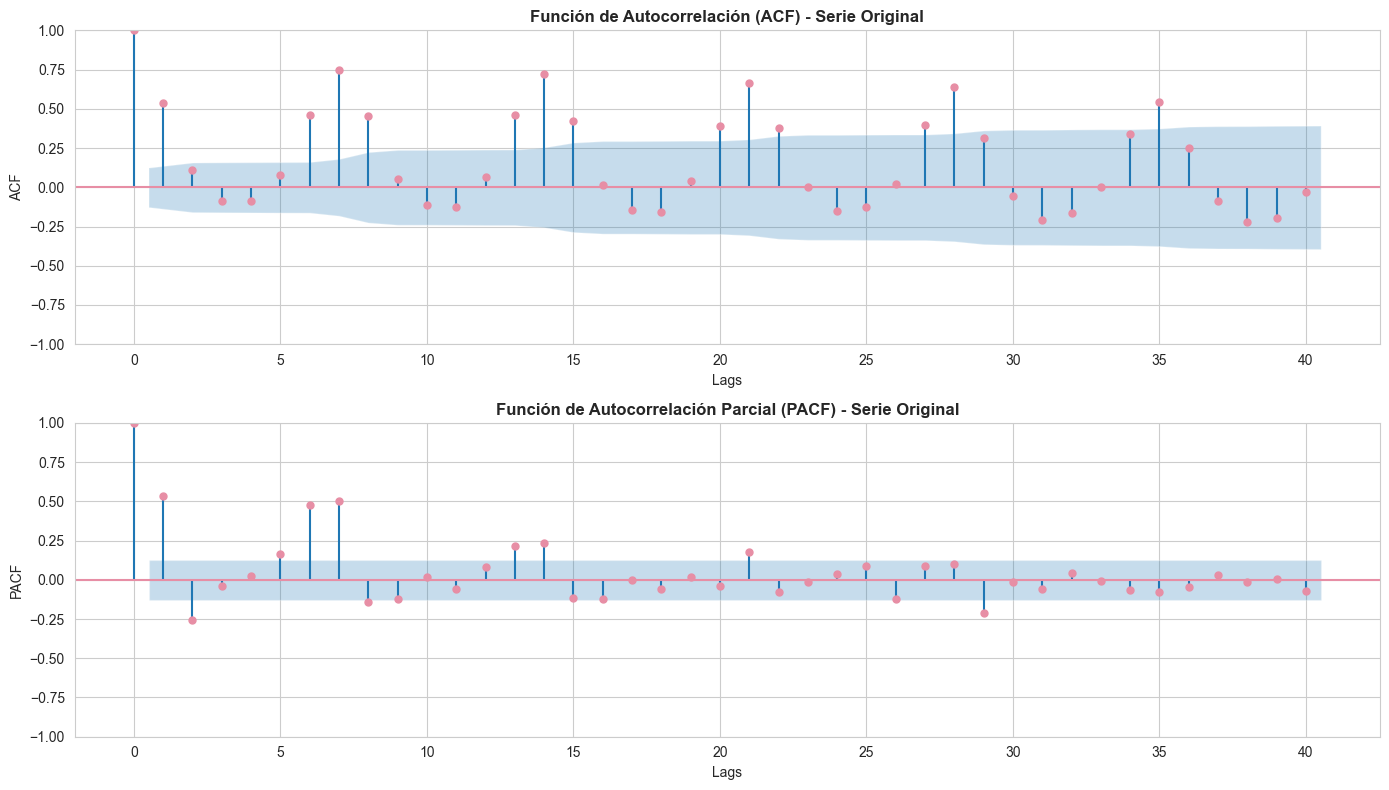


=== INTERPRETACIÓN ACF/PACF ===
ACF: Si decae lentamente → indica NO estacionariedad o tendencia
PACF: Corte abrupto en lag k → sugiere AR(k)
ACF: Corte abrupto en lag k → sugiere MA(k)
Ambos decaen gradualmente → sugiere ARMA(p,q)


In [5]:
# 3.1 Plot ACF and PACF for original series
fig, axes = plt.subplots(2, 1, figsize=(14, 8))

# ACF
plot_acf(data_og['Ventas'].dropna(), lags=40, ax=axes[0], color='#e78ea5')
axes[0].set_title('Función de Autocorrelación (ACF) - Serie Original',
                  fontsize=12, fontweight='bold')
axes[0].set_xlabel('Lags')
axes[0].set_ylabel('ACF')

# PACF
plot_pacf(data_og['Ventas'].dropna(), lags=40, ax=axes[1],
          color='#e78ea5', method='ywm')
axes[1].set_title('Función de Autocorrelación Parcial (PACF) - Serie Original',
                  fontsize=12, fontweight='bold')
axes[1].set_xlabel('Lags')
axes[1].set_ylabel('PACF')

plt.tight_layout()
plt.show()

# 3.2 Interpretación visual
print("\n=== INTERPRETACIÓN ACF/PACF ===")
print("ACF: Si decae lentamente → indica NO estacionariedad o tendencia")
print("PACF: Corte abrupto en lag k → sugiere AR(k)")
print("ACF: Corte abrupto en lag k → sugiere MA(k)")
print("Ambos decaen gradualmente → sugiere ARMA(p,q)")

In [10]:
# COMPREHENSIVE DIFFERENCING ANALYSIS
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Set up for testing multiple differencing orders
max_d = 4
results_differencing = []

print(f"\n{'='*80}")
print(f"ANÁLISIS SISTEMÁTICO DE DIFERENCIACIÓN (d = 0 hasta {max_d})")
print(f"{'='*80}\n")

# Create differenced series
diff_series = {
    0: data_og['Ventas'],
    1: data_og['Ventas'].diff(),
    2: data_og['Ventas'].diff().diff(),
    3: data_og['Ventas'].diff().diff().diff(),
    4: data_og['Ventas'].diff().diff().diff().diff()
}

# Run tests for each d
for d in range(max_d + 1):
    print(f"\n{'─'*80}")
    print(f"PRUEBAS PARA d = {d}")
    print(f"{'─'*80}")

    series = diff_series[d].dropna()

    # ADF Test
    adf_result = adfuller(series)
    adf_stat = adf_result[0]
    adf_pvalue = adf_result[1]

    # KPSS Test
    try:
        kpss_result = kpss(series, regression='ct', nlags='auto')
        kpss_stat = kpss_result[0]
        kpss_pvalue = kpss_result[1]
    except:
        kpss_stat = np.nan
        kpss_pvalue = np.nan

    # Variance
    variance = series.var()

    # Mean (should be close to 0)
    mean = series.mean()

    # Autocorrelation at lag 1 (should not be too negative)
    acf_lag1 = series.autocorr(lag=1)

    print(f"\n📊 Estadísticas:")
    print(f"  Media: {mean:.4f}")
    print(f"  Varianza: {variance:.4f}")
    print(f"  ACF(1): {acf_lag1:.4f}")

    print(f"\n📈 ADF Test:")
    print(f"  Estadístico: {adf_stat:.4f}")
    print(f"  p-value: {adf_pvalue:.6f}")
    if adf_pvalue <= 0.05:
        print(f"  ✓ ESTACIONARIA (p ≤ 0.05)")
        adf_result_text = "✓ Estacionaria"
    else:
        print(f"  ✗ NO ESTACIONARIA (p > 0.05)")
        adf_result_text = "✗ No Estacionaria"

    print(f"\n📉 KPSS Test:")
    if not np.isnan(kpss_pvalue):
        print(f"  Estadístico: {kpss_stat:.4f}")
        print(f"  p-value: {kpss_pvalue:.6f}")
        if kpss_pvalue >= 0.05:
            print(f"  ✓ ESTACIONARIA (p ≥ 0.05)")
            kpss_result_text = "✓ Estacionaria"
        else:
            print(f"  ✗ NO ESTACIONARIA (p < 0.05)")
            kpss_result_text = "✗ No Estacionaria"
    else:
        print(f"  ⚠ No se pudo calcular")
        kpss_result_text = "N/A"

    # Store results
    results_differencing.append({
        'd': d,
        'ADF_stat': adf_stat,
        'ADF_pvalue': adf_pvalue,
        'ADF_result': adf_result_text,
        'KPSS_stat': kpss_stat,
        'KPSS_pvalue': kpss_pvalue,
        'KPSS_result': kpss_result_text,
        'Mean': mean,
        'Variance': variance,
        'ACF_lag1': acf_lag1
    })

# Create summary table
diff_results_df = pd.DataFrame(results_differencing)

print(f"\n\n{'='*80}")
print("TABLA COMPARATIVA DE DIFERENCIACIÓN")
print(f"{'='*80}\n")
print(diff_results_df[['d', 'ADF_pvalue', 'ADF_result', 'KPSS_pvalue',
                        'KPSS_result', 'Variance', 'ACF_lag1']].to_string(index=False))


ANÁLISIS SISTEMÁTICO DE DIFERENCIACIÓN (d = 0 hasta 4)


────────────────────────────────────────────────────────────────────────────────
PRUEBAS PARA d = 0
────────────────────────────────────────────────────────────────────────────────

📊 Estadísticas:
  Media: 223.6198
  Varianza: 5678.3528
  ACF(1): 0.5398

📈 ADF Test:
  Estadístico: -1.6057
  p-value: 0.480731
  ✗ NO ESTACIONARIA (p > 0.05)

📉 KPSS Test:
  Estadístico: 0.7078
  p-value: 0.010000
  ✗ NO ESTACIONARIA (p < 0.05)

────────────────────────────────────────────────────────────────────────────────
PRUEBAS PARA d = 1
────────────────────────────────────────────────────────────────────────────────

📊 Estadísticas:
  Media: 0.4191
  Varianza: 5225.8528
  ACF(1): -0.0316

📈 ADF Test:
  Estadístico: -5.6186
  p-value: 0.000001
  ✓ ESTACIONARIA (p ≤ 0.05)

📉 KPSS Test:
  Estadístico: 0.5000
  p-value: 0.010000
  ✗ NO ESTACIONARIA (p < 0.05)

────────────────────────────────────────────────────────────────────────────────
PRUEB

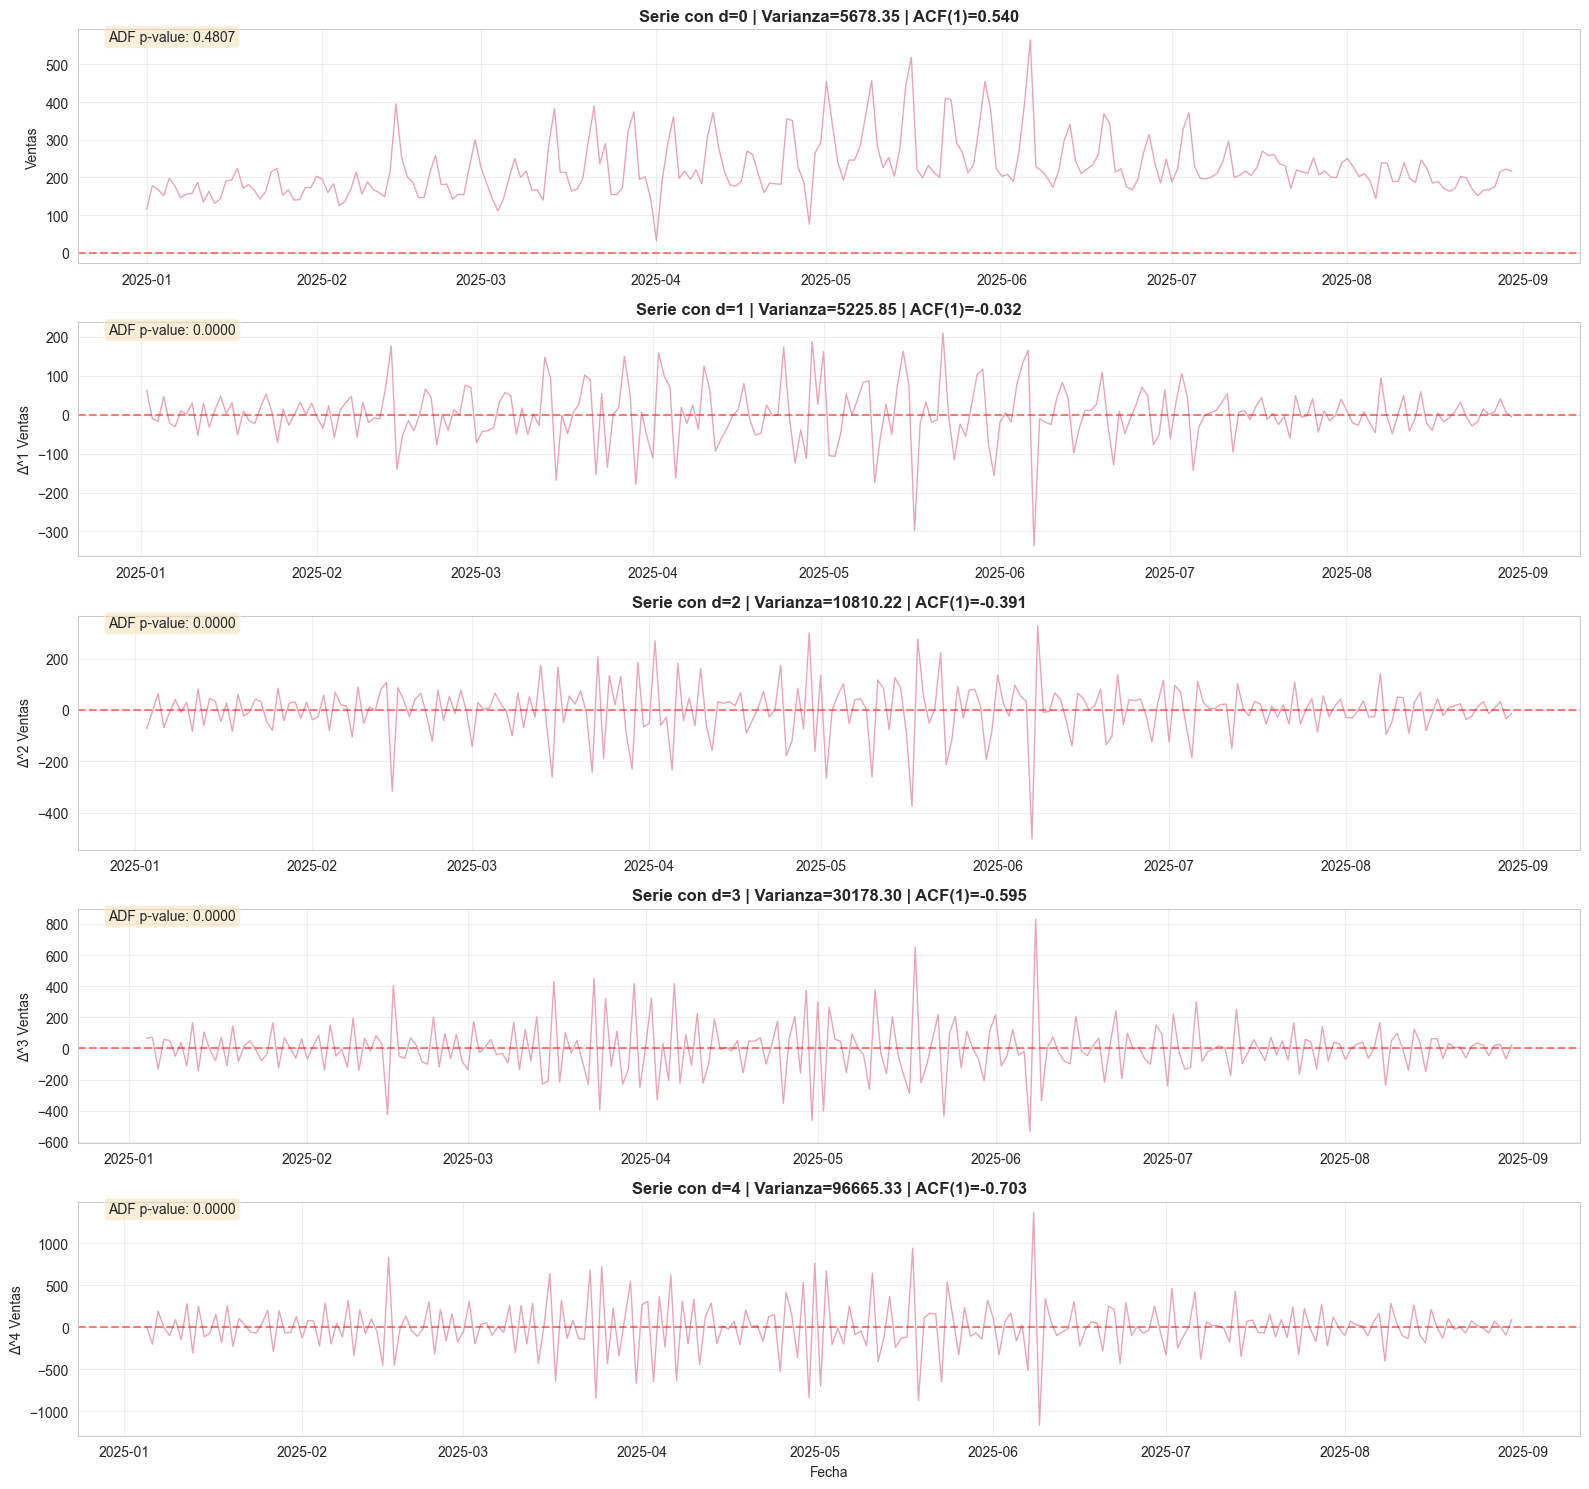

In [11]:
# Visualize all differenced series
fig, axes = plt.subplots(5, 1, figsize=(16, 15))

for d in range(5):
    series = diff_series[d].dropna()

    axes[d].plot(series.index, series.values, color='#e78ea5', linewidth=1, alpha=0.8)
    axes[d].axhline(y=0, color='red', linestyle='--', alpha=0.5)
    axes[d].set_title(f'Serie con d={d} | Varianza={series.var():.2f} | ACF(1)={series.autocorr(1):.3f}',
                      fontsize=12, fontweight='bold')
    axes[d].set_ylabel(f'Δ^{d} Ventas' if d > 0 else 'Ventas')
    axes[d].grid(alpha=0.3)

    # Add ADF p-value annotation
    adf_pval = diff_results_df[diff_results_df['d']==d]['ADF_pvalue'].values[0]
    axes[d].text(0.02, 0.95, f'ADF p-value: {adf_pval:.4f}',
                transform=axes[d].transAxes, fontsize=10,
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

axes[-1].set_xlabel('Fecha')
plt.tight_layout()
plt.show()

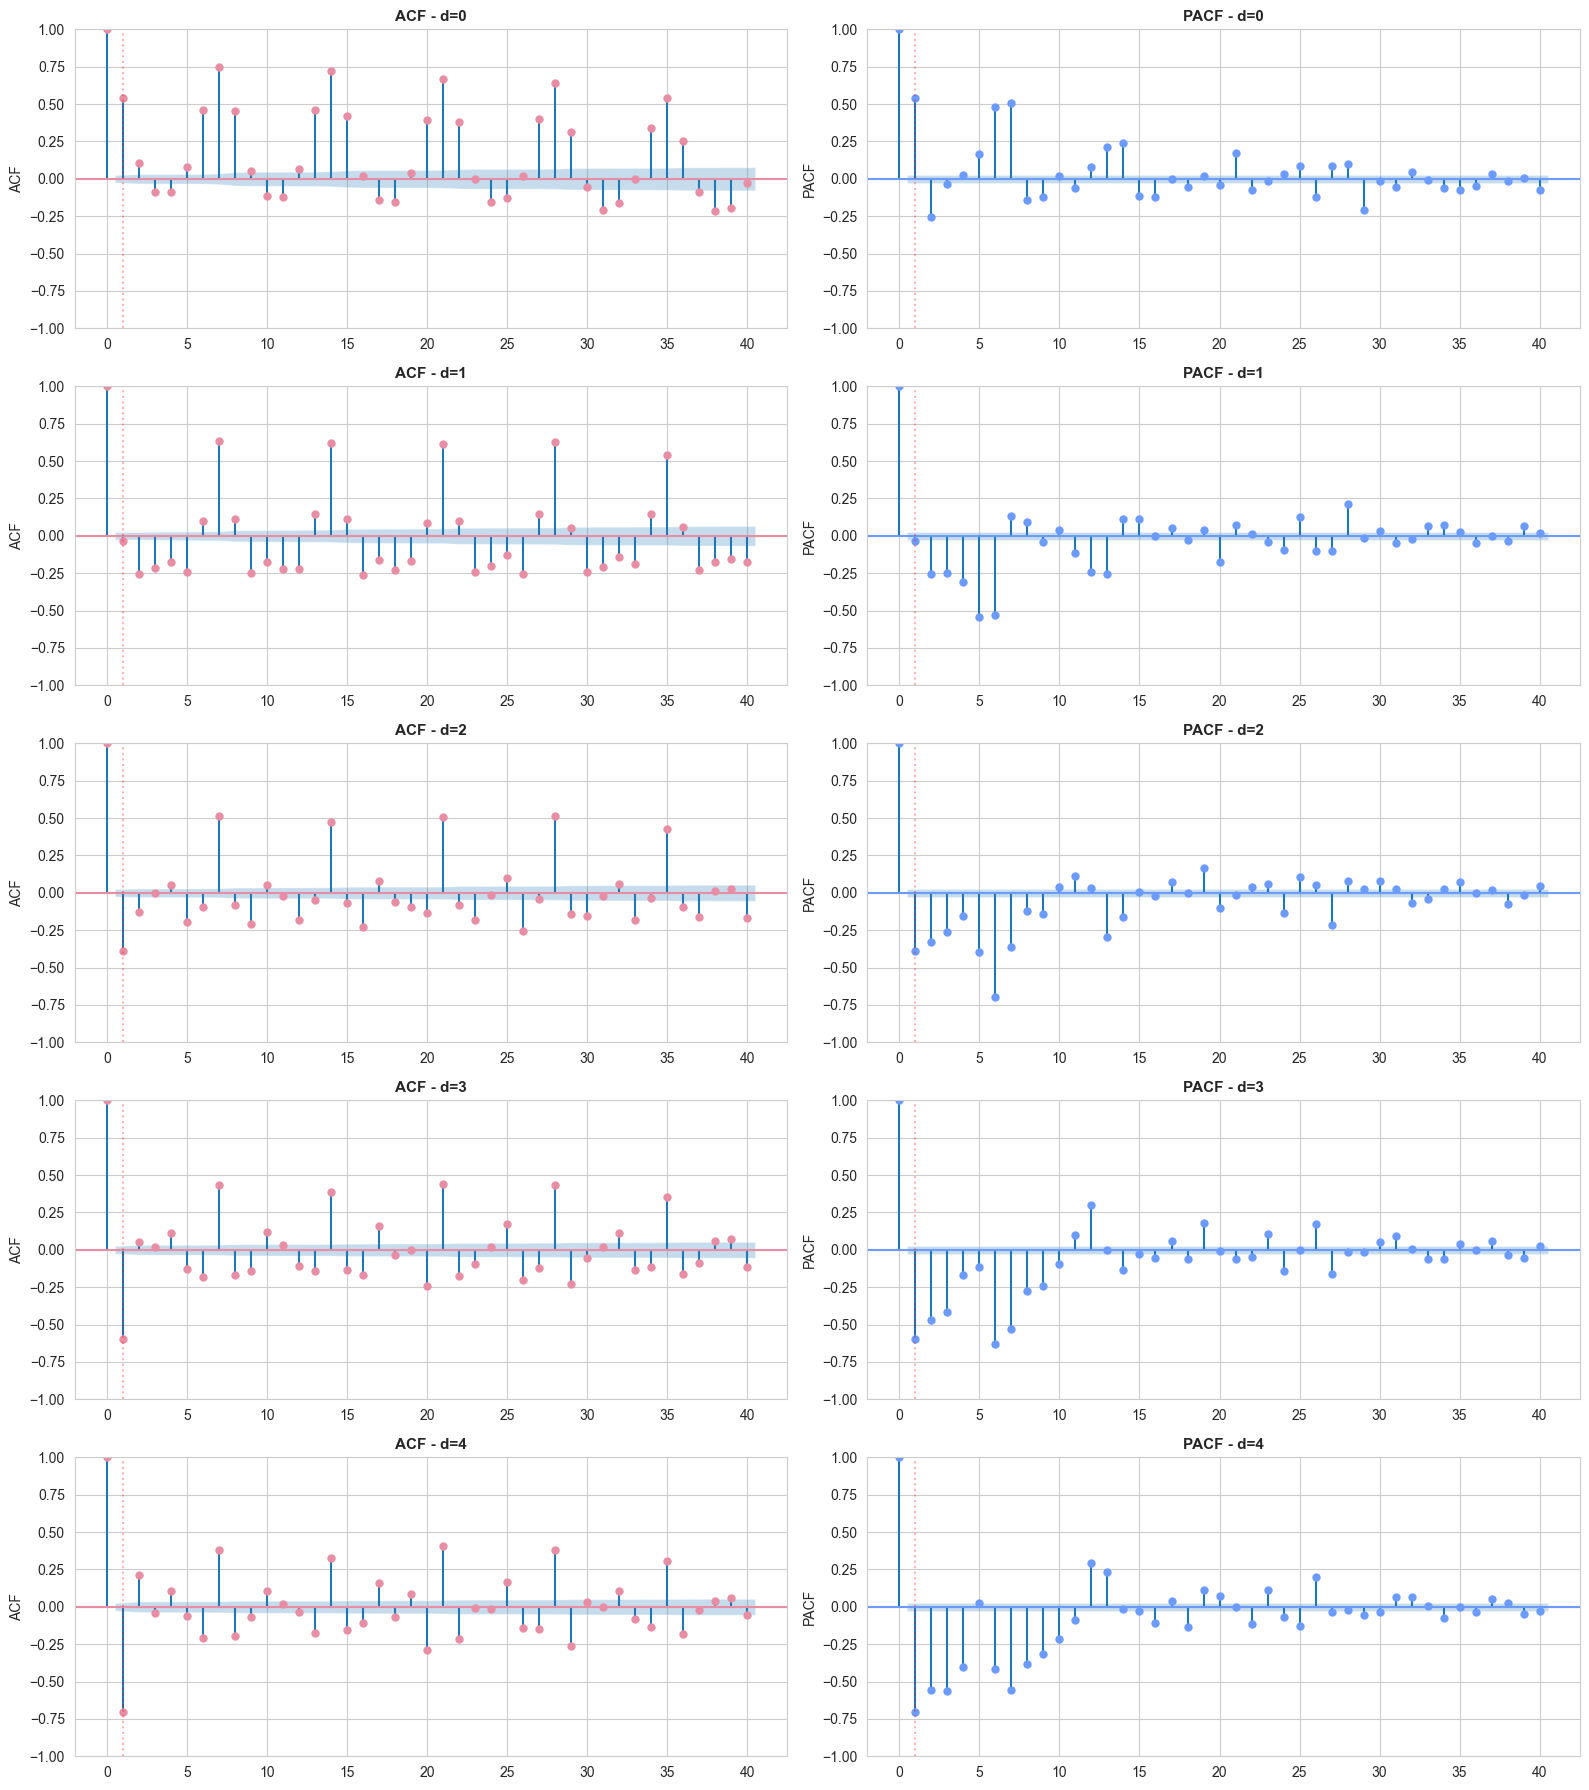


INTERPRETACIÓN DE ACF/PACF PARA DETECTAR SOBRE-DIFERENCIACIÓN

🔍 Señales de SOBRE-DIFERENCIACIÓN:

1. ACF(1) fuertemente NEGATIVO (< -0.3)
   → Indica que diferenciaste demasiado

2. PACF(1) fuertemente NEGATIVO (< -0.5)
   → Modelo está "sobre-ajustado" por diferenciación excesiva

3. Varianza AUMENTA con más diferenciación
   → Estás añadiendo ruido innecesario

4. ACF oscila fuertemente entre + y -
   → Patrón artificial creado por sobre-diferenciación

✓ Regla de oro: Usa el MENOR d que haga la serie estacionaria



In [12]:
# ACF/PACF for different d values
fig, axes = plt.subplots(5, 2, figsize=(16, 18))

for d in range(5):
    series = diff_series[d].dropna()

    # ACF
    plot_acf(series, lags=40, ax=axes[d, 0], color='#e78ea5', alpha=0.7)
    axes[d, 0].set_title(f'ACF - d={d}', fontsize=11, fontweight='bold')
    axes[d, 0].set_ylabel('ACF')

    # PACF
    plot_pacf(series, lags=40, ax=axes[d, 1], color='#6b9bff',
              method='ywm', alpha=0.7)
    axes[d, 1].set_title(f'PACF - d={d}', fontsize=11, fontweight='bold')
    axes[d, 1].set_ylabel('PACF')

    # Highlight lag 1
    axes[d, 0].axvline(x=1, color='red', linestyle=':', alpha=0.3)
    axes[d, 1].axvline(x=1, color='red', linestyle=':', alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("INTERPRETACIÓN DE ACF/PACF PARA DETECTAR SOBRE-DIFERENCIACIÓN")
print("="*80)
print("""
🔍 Señales de SOBRE-DIFERENCIACIÓN:

1. ACF(1) fuertemente NEGATIVO (< -0.3)
   → Indica que diferenciaste demasiado

2. PACF(1) fuertemente NEGATIVO (< -0.5)
   → Modelo está "sobre-ajustado" por diferenciación excesiva

3. Varianza AUMENTA con más diferenciación
   → Estás añadiendo ruido innecesario

4. ACF oscila fuertemente entre + y -
   → Patrón artificial creado por sobre-diferenciación

✓ Regla de oro: Usa el MENOR d que haga la serie estacionaria
""")

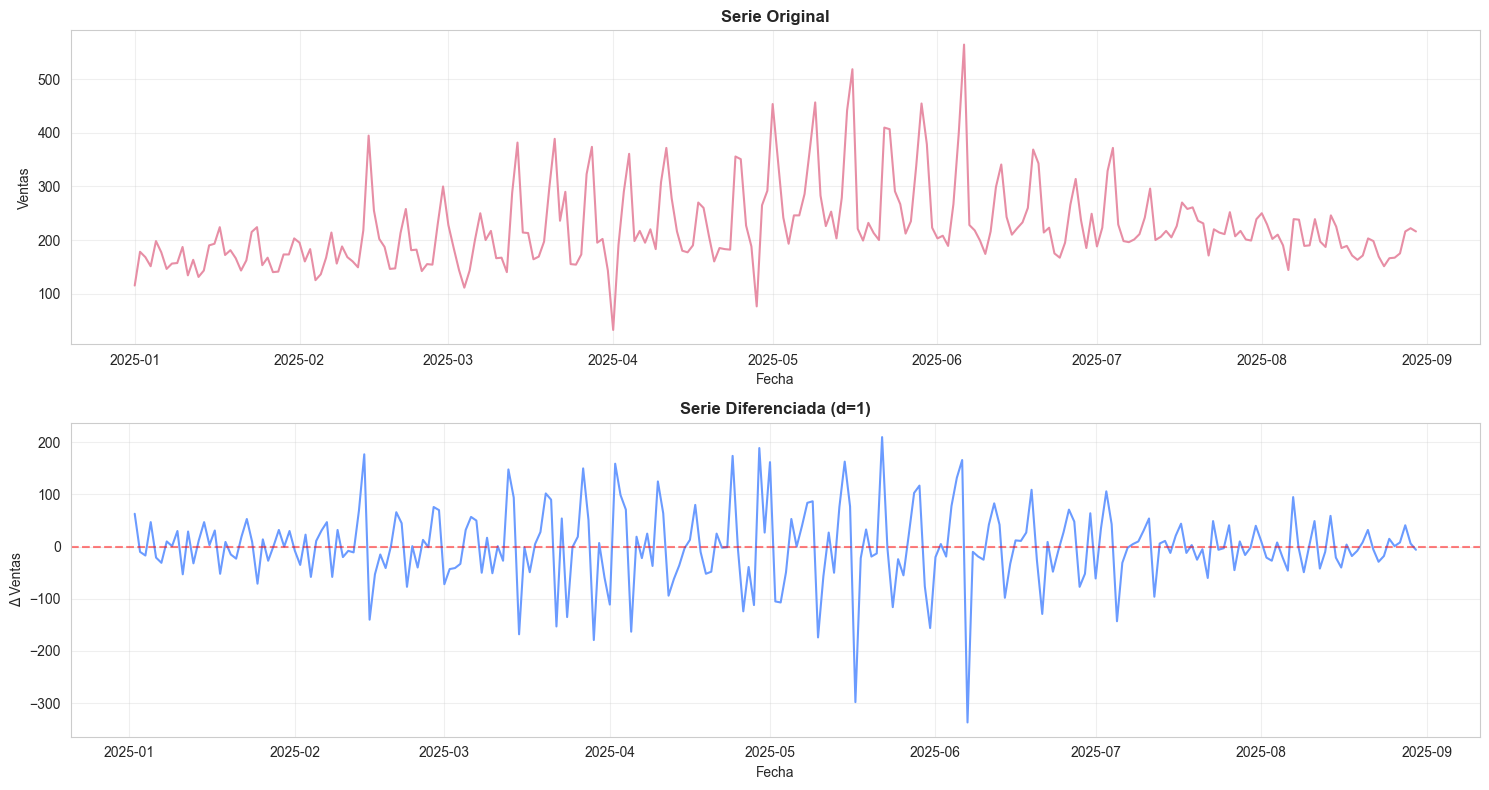


PRUEBAS DE ESTACIONARIEDAD - SERIE DIFERENCIADA (d=1)

=== ADF TEST - Serie Diferenciada (d=1) ===
ADF Statistic: -5.618650
p-value: 0.000001
Critical Values:
	1%: -3.460
	5%: -2.874
	10%: -2.574
✓ Rechazamos H0: La serie ES ESTACIONARIA (p < 0.05)

=== KPSS TEST - Serie Diferenciada (d=1) ===
KPSS Statistic: 0.500000
p-value: 0.010000
Critical Values:
	10%: 0.119
	5%: 0.146
	2.5%: 0.176
	1%: 0.216
✗ Rechazamos H0: La serie NO ES ESTACIONARIA (p < 0.05)

PRUEBAS DE ESTACIONARIEDAD - SERIE DIFERENCIADA (d=2)

=== ADF TEST - Serie Diferenciada (d=2) ===
ADF Statistic: -9.189295
p-value: 0.000000
Critical Values:
	1%: -3.460
	5%: -2.875
	10%: -2.574
✓ Rechazamos H0: La serie ES ESTACIONARIA (p < 0.05)

=== KPSS TEST - Serie Diferenciada (d=2) ===
KPSS Statistic: 0.151224
p-value: 0.045647
Critical Values:
	10%: 0.119
	5%: 0.146
	2.5%: 0.176
	1%: 0.216
✗ Rechazamos H0: La serie NO ES ESTACIONARIA (p < 0.05)


In [13]:
# 4.1 Primera diferenciación
data_og['Ventas_diff1'] = data_og['Ventas'].diff()

# Visualizar serie diferenciada
fig, axes = plt.subplots(2, 1, figsize=(15, 8))

# Serie original
axes[0].plot(data_og.index, data_og['Ventas'], color='#e78ea5', linewidth=1.5)
axes[0].set_title('Serie Original', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Fecha')
axes[0].set_ylabel('Ventas')
axes[0].grid(alpha=0.3)

# Serie diferenciada (d=1)
axes[1].plot(data_og.index, data_og['Ventas_diff1'], color='#6b9bff', linewidth=1.5)
axes[1].axhline(y=0, color='red', linestyle='--', alpha=0.5)
axes[1].set_title('Serie Diferenciada (d=1)', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Fecha')
axes[1].set_ylabel('Δ Ventas')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# 4.2 Pruebas de estacionariedad en serie diferenciada
print(f"\n{'='*60}")
print(f"PRUEBAS DE ESTACIONARIEDAD - SERIE DIFERENCIADA (d=1)")
print(f"{'='*60}")

adf_result_diff = adf_test(data_og['Ventas_diff1'].dropna(), 'Serie Diferenciada (d=1)')
kpss_result_diff = kpss_test(data_og['Ventas_diff1'].dropna(), 'Serie Diferenciada (d=1)')

# 4.3 Si se necesita segunda diferenciación
data_og['Ventas_diff2'] = data_og['Ventas_diff1'].diff()

# Test segunda diferenciación (solo si la primera no fue suficiente)
# Descomentar si es necesario:
print(f"\n{'='*60}")
print(f"PRUEBAS DE ESTACIONARIEDAD - SERIE DIFERENCIADA (d=2)")
print(f"{'='*60}")
adf_result_diff2 = adf_test(data_og['Ventas_diff2'].dropna(), 'Serie Diferenciada (d=2)')
kpss_result_diff2 = kpss_test(data_og['Ventas_diff2'].dropna(), 'Serie Diferenciada (d=2)')


STEP 5: ANÁLISIS ACF/PACF CON d=1 (ÓPTIMO)

Serie diferenciada seleccionada: d = 1
Razón: Mínima varianza (5225.85), ACF(1) ≈ 0 (-0.032)
Observaciones: 241


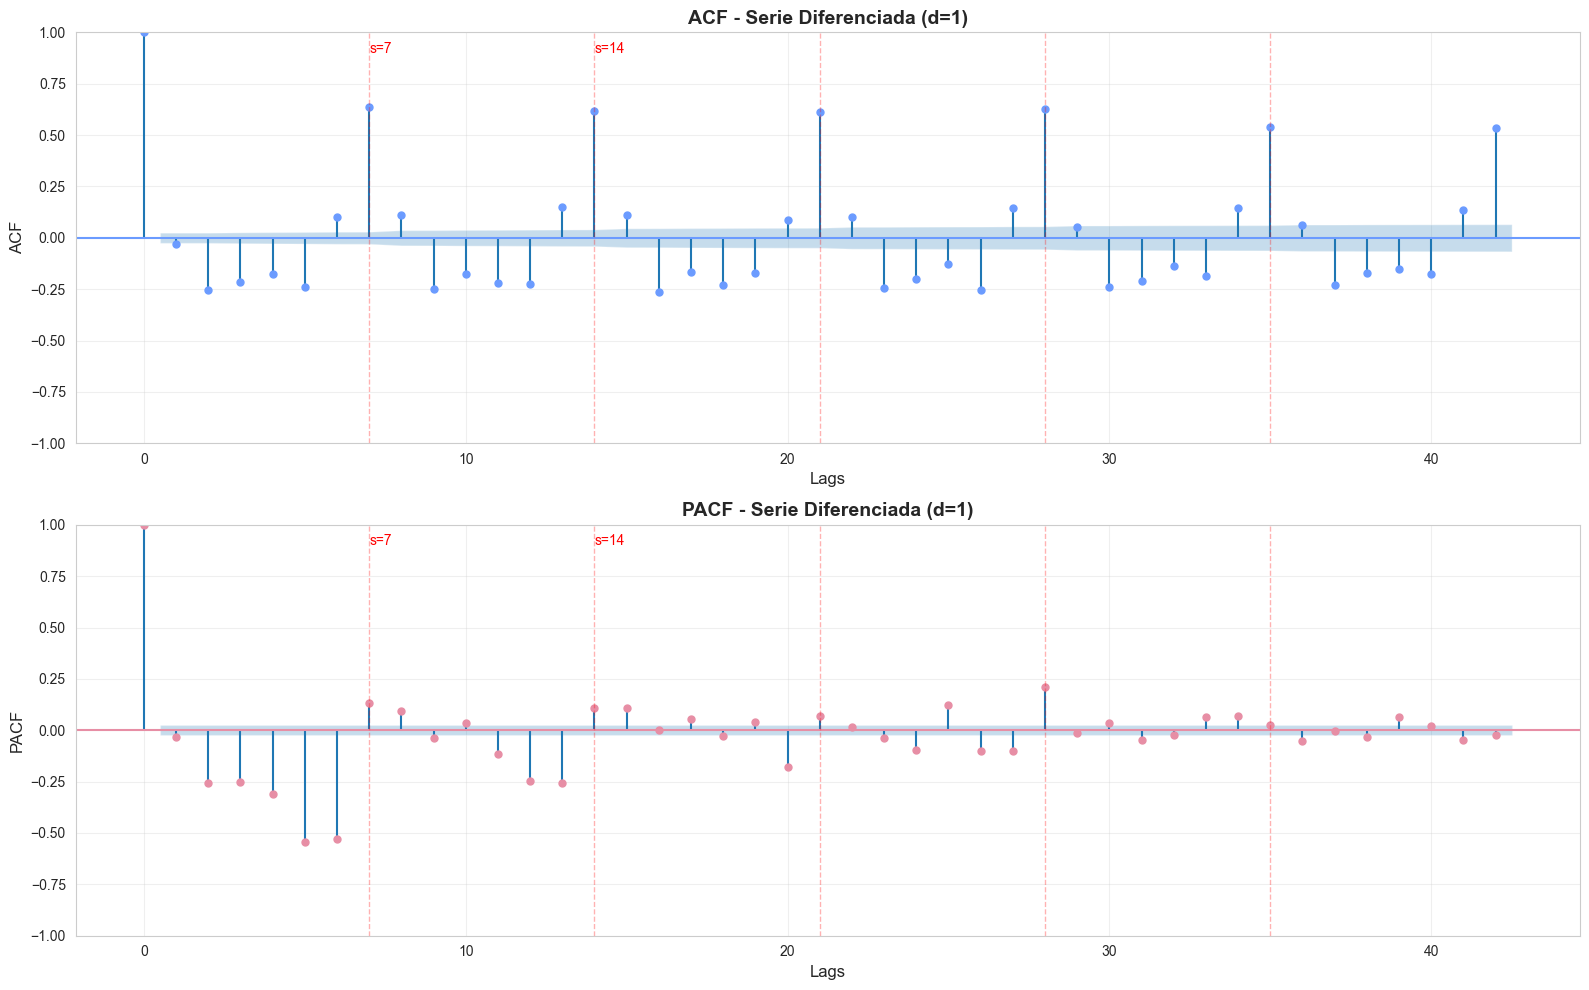


IDENTIFICACIÓN DE PARÁMETROS PARA SARIMA(p,1,q)(P,D,Q)₇

📊 PARÁMETROS NO ESTACIONALES (p, q):
--------------------------------------------------------------------------------
Observa los lags 1-6 en ACF y PACF:
  • PACF: Cortes significativos en lags 1-6 → sugieren valor de p
  • ACF:  Cortes significativos en lags 1-6 → sugieren valor de q

Interpretación típica:
  - Si PACF decae y ACF corta → MA(q)
  - Si ACF decae y PACF corta → AR(p)
  - Si ambos decaen gradualmente → ARMA(p,q)

📊 PARÁMETROS ESTACIONALES (P, Q) con s=7:
--------------------------------------------------------------------------------
Observa los lags múltiplos de 7 (7, 14, 21, 28...) en ACF y PACF:
  • PACF en lag 7: Corte significativo → sugiere P=1
  • ACF en lag 7:  Corte significativo → sugiere Q=1

Diferenciación estacional D:
  • D=0: Si la diferenciación regular (d=1) removió la estacionalidad
  • D=1: Si aún hay patrón estacional fuerte en lags 7, 14, 21...

📊 RECOMENDACIÓN INICIAL (para empezar el grid se

In [14]:
# ============================================================================
# STEP 5: ACF/PACF ANALYSIS OF OPTIMAL DIFFERENCED SERIES (d=1)
# ============================================================================

print("\n" + "="*80)
print("STEP 5: ANÁLISIS ACF/PACF CON d=1 (ÓPTIMO)")
print("="*80 + "\n")

# Use d=1 differenced series
d_optimal = 1
series_diff = data_og['Ventas'].diff().dropna()

print(f"Serie diferenciada seleccionada: d = {d_optimal}")
print(f"Razón: Mínima varianza ({5225.85:.2f}), ACF(1) ≈ 0 (-0.032)")
print(f"Observaciones: {len(series_diff)}")

# Create comprehensive ACF/PACF plot
fig, axes = plt.subplots(2, 1, figsize=(16, 10))

# ACF
plot_acf(series_diff, lags=42, ax=axes[0], color='#6b9bff', alpha=0.7)
axes[0].set_title(f'ACF - Serie Diferenciada (d={d_optimal})',
                  fontsize=14, fontweight='bold')
axes[0].set_xlabel('Lags', fontsize=12)
axes[0].set_ylabel('ACF', fontsize=12)

# Highlight seasonal lags
for lag in [7, 14, 21, 28, 35]:
    axes[0].axvline(x=lag, color='red', linestyle='--', alpha=0.3, linewidth=1)
axes[0].text(7, 0.9, 's=7', fontsize=10, color='red')
axes[0].text(14, 0.9, 's=14', fontsize=10, color='red')
axes[0].grid(alpha=0.3)

# PACF
plot_pacf(series_diff, lags=42, ax=axes[1], color='#e78ea5',
          method='ywm', alpha=0.7)
axes[1].set_title(f'PACF - Serie Diferenciada (d={d_optimal})',
                  fontsize=14, fontweight='bold')
axes[1].set_xlabel('Lags', fontsize=12)
axes[1].set_ylabel('PACF', fontsize=12)

# Highlight seasonal lags
for lag in [7, 14, 21, 28, 35]:
    axes[1].axvline(x=lag, color='red', linestyle='--', alpha=0.3, linewidth=1)
axes[1].text(7, 0.9, 's=7', fontsize=10, color='red')
axes[1].text(14, 0.9, 's=14', fontsize=10, color='red')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# ============================================================================
# IDENTIFICACIÓN VISUAL DE PARÁMETROS
# ============================================================================

print("\n" + "="*80)
print("IDENTIFICACIÓN DE PARÁMETROS PARA SARIMA(p,1,q)(P,D,Q)₇")
print("="*80 + "\n")

print("📊 PARÁMETROS NO ESTACIONALES (p, q):")
print("-" * 80)
print("Observa los lags 1-6 en ACF y PACF:")
print("  • PACF: Cortes significativos en lags 1-6 → sugieren valor de p")
print("  • ACF:  Cortes significativos en lags 1-6 → sugieren valor de q")
print("\nInterpretación típica:")
print("  - Si PACF decae y ACF corta → MA(q)")
print("  - Si ACF decae y PACF corta → AR(p)")
print("  - Si ambos decaen gradualmente → ARMA(p,q)")

print("\n📊 PARÁMETROS ESTACIONALES (P, Q) con s=7:")
print("-" * 80)
print("Observa los lags múltiplos de 7 (7, 14, 21, 28...) en ACF y PACF:")
print("  • PACF en lag 7: Corte significativo → sugiere P=1")
print("  • ACF en lag 7:  Corte significativo → sugiere Q=1")
print("\nDiferenciación estacional D:")
print("  • D=0: Si la diferenciación regular (d=1) removió la estacionalidad")
print("  • D=1: Si aún hay patrón estacional fuerte en lags 7, 14, 21...")

print("\n📊 RECOMENDACIÓN INICIAL (para empezar el grid search):")
print("-" * 80)
print("Basado en las gráficas ACF/PACF:")
print("  • p: Probar rango 0-2")
print("  • d: FIJO en 1 ✓")
print("  • q: Probar rango 0-2")
print("  • P: Probar 0-1")
print("  • D: Probar 0 y 1")
print("  • Q: Probar 0-1")
print("  • s: FIJO en 7 ✓")

print("\n⚠️ NOTA IMPORTANTE:")
print("El componente estacional (P,D,Q)₇ manejará los picos en lags 7, 14, 21...")
print("NO necesitamos d=4 o d=7 - ese era un error conceptual común!")

In [15]:
# ============================================================================
# STEP 6: OPTIMIZACIÓN DE PARÁMETROS SARIMA(p,1,q)(P,D,Q)₇
# ============================================================================

import warnings
warnings.filterwarnings('ignore')

print("\n" + "="*80)
print("STEP 6: OPTIMIZACIÓN SARIMA - GRID SEARCH COMPLETO")
print("="*80 + "\n")

# Define parameter ranges based on ACF/PACF analysis
p_range = [0, 1, 2]        # Non-seasonal AR
d = 1                       # FIXED - confirmed optimal
q_range = [0, 1, 2]        # Non-seasonal MA

P_range = [0, 1]           # Seasonal AR
D_range = [0, 1]           # Seasonal differencing - BOTH to compare
Q_range = [0, 1]           # Seasonal MA
s = 7                       # FIXED - weekly seasonality

print("Rango de parámetros a probar:")
print(f"  p (AR no estacional): {p_range}")
print(f"  d (Diferenciación): {d} (FIJO)")
print(f"  q (MA no estacional): {q_range}")
print(f"  P (AR estacional): {P_range}")
print(f"  D (Diferenciación estacional): {D_range}")
print(f"  Q (MA estacional): {Q_range}")
print(f"  s (Período estacional): {s} (FIJO)")

total_combinations = (len(p_range) * len(q_range) *
                     len(P_range) * len(D_range) * len(Q_range))
print(f"\nTotal de combinaciones a probar: {total_combinations}")
print("Estimación de tiempo: 2-5 minutos\n")
print("="*80)

# Function to optimize SARIMA
def optimize_sarima_comprehensive(data, p_range, d, q_range,
                                 P_range, D_range, Q_range, s):
    '''
    Optimiza parámetros SARIMA mediante grid search exhaustivo

    Returns:
        DataFrame con todas las combinaciones ordenadas por AIC
    '''
    results = []

    total = len(p_range) * len(q_range) * len(P_range) * len(D_range) * len(Q_range)
    count = 0
    failed = 0

    print("Iniciando optimización...\n")

    for p in p_range:
        for q in q_range:
            for P in P_range:
                for D in D_range:
                    for Q in Q_range:
                        count += 1

                        # Progress indicator
                        if count % 5 == 0 or count == total:
                            pct = (count / total) * 100
                            print(f"Progreso: {count}/{total} ({pct:.1f}%) | "
                                  f"Exitosos: {len(results)} | Fallidos: {failed}",
                                  end='\r')

                        try:
                            # Skip if both p and q are 0 (no ARMA structure)
                            if p == 0 and q == 0:
                                continue

                            # Fit SARIMA model
                            model = SARIMAX(data,
                                          order=(p, d, q),
                                          seasonal_order=(P, D, Q, s),
                                          enforce_stationarity=False,
                                          enforce_invertibility=False)

                            fitted = model.fit(disp=False,
                                             maxiter=200,
                                             method='lbfgs')

                            # Store results
                            results.append({
                                'Order': f'({p},{d},{q})({P},{D},{Q}){s}',
                                'p': p, 'd': d, 'q': q,
                                'P': P, 'D': D, 'Q': Q, 's': s,
                                'AIC': fitted.aic,
                                'BIC': fitted.bic,
                                'Log_Likelihood': fitted.llf,
                                'Params': p + q + P + Q
                            })

                        except Exception as e:
                            failed += 1
                            continue

    print(f"\n\nOptimización completada!")
    print(f"Modelos exitosos: {len(results)}")
    print(f"Modelos fallidos: {failed}")
    print("="*80 + "\n")

    # Create DataFrame and sort by AIC
    if len(results) > 0:
        results_df = pd.DataFrame(results)
        results_df = results_df.sort_values('AIC').reset_index(drop=True)
        return results_df
    else:
        print("⚠️ ERROR: Ningún modelo convergió exitosamente")
        return pd.DataFrame()

# Execute optimization
results_sarima = optimize_sarima_comprehensive(
    data_og['Ventas'],
    p_range, d, q_range,
    P_range, D_range, Q_range,
    s
)

# Display results
if len(results_sarima) > 0:
    print("\n" + "="*80)
    print("TOP 15 MEJORES MODELOS SARIMA (ordenados por AIC)")
    print("="*80 + "\n")

    display_cols = ['Order', 'AIC', 'BIC', 'Log_Likelihood', 'Params']
    print(results_sarima[display_cols].head(15).to_string(index=True))

    # Select best model
    best_model = results_sarima.iloc[0]

    print("\n" + "="*80)
    print("🏆 MEJOR MODELO SELECCIONADO")
    print("="*80)
    print(f"\nModelo: SARIMA{best_model['Order']}")
    print(f"\nParámetros:")
    print(f"  • No estacionales: p={int(best_model['p'])}, "
          f"d={int(best_model['d'])}, q={int(best_model['q'])}")
    print(f"  • Estacionales: P={int(best_model['P'])}, "
          f"D={int(best_model['D'])}, Q={int(best_model['Q'])}, s={int(best_model['s'])}")
    print(f"\nMétricas:")
    print(f"  • AIC: {best_model['AIC']:.4f}")
    print(f"  • BIC: {best_model['BIC']:.4f}")
    print(f"  • Log-Likelihood: {best_model['Log_Likelihood']:.4f}")
    print(f"  • Parámetros totales: {int(best_model['Params'])}")

    # Store best parameters for next steps
    best_p = int(best_model['p'])
    best_d = int(best_model['d'])
    best_q = int(best_model['q'])
    best_P = int(best_model['P'])
    best_D = int(best_model['D'])
    best_Q = int(best_model['Q'])
    best_s = int(best_model['s'])

    # Compare models with D=0 vs D=1
    print("\n" + "="*80)
    print("COMPARACIÓN: D=0 vs D=1")
    print("="*80 + "\n")

    models_D0 = results_sarima[results_sarima['D'] == 0].head(3)
    models_D1 = results_sarima[results_sarima['D'] == 1].head(3)

    if len(models_D0) > 0:
        print("Mejores 3 modelos con D=0 (sin diferenciación estacional):")
        print(models_D0[display_cols].to_string(index=False))
        best_D0_aic = models_D0.iloc[0]['AIC']
    else:
        print("No hay modelos con D=0 que convergieron")
        best_D0_aic = np.inf

    print("\n")

    if len(models_D1) > 0:
        print("Mejores 3 modelos con D=1 (con diferenciación estacional):")
        print(models_D1[display_cols].to_string(index=False))
        best_D1_aic = models_D1.iloc[0]['AIC']
    else:
        print("No hay modelos con D=1 que convergieron")
        best_D1_aic = np.inf

    # Determine which D is better
    print("\n" + "-"*80)
    if best_D1_aic < best_D0_aic:
        improvement = ((best_D0_aic - best_D1_aic) / best_D0_aic) * 100
        print(f"✓ D=1 es MEJOR que D=0")
        print(f"  Mejora en AIC: {improvement:.2f}%")
        print(f"  Conclusión: La diferenciación estacional ES necesaria")
    else:
        deterioration = ((best_D1_aic - best_D0_aic) / best_D0_aic) * 100
        print(f"✓ D=0 es MEJOR que D=1")
        print(f"  Diferencia en AIC: {deterioration:.2f}%")
        print(f"  Conclusión: La diferenciación estacional NO es necesaria")

else:
    print("\n⚠️ ERROR: No se pudieron ajustar modelos SARIMA")
    print("Revisa los datos de entrada y parámetros")


STEP 6: OPTIMIZACIÓN SARIMA - GRID SEARCH COMPLETO

Rango de parámetros a probar:
  p (AR no estacional): [0, 1, 2]
  d (Diferenciación): 1 (FIJO)
  q (MA no estacional): [0, 1, 2]
  P (AR estacional): [0, 1]
  D (Diferenciación estacional): [0, 1]
  Q (MA estacional): [0, 1]
  s (Período estacional): 7 (FIJO)

Total de combinaciones a probar: 72
Estimación de tiempo: 2-5 minutos

Iniciando optimización...

Progreso: 72/72 (100.0%) | Exitosos: 63 | Fallidos: 0

Optimización completada!
Modelos exitosos: 64
Modelos fallidos: 0


TOP 15 MEJORES MODELOS SARIMA (ordenados por AIC)

              Order          AIC          BIC  Log_Likelihood  Params
0   (1,1,2)(0,1,1)7  2325.610092  2342.668322    -1157.805046       4
1   (0,1,2)(0,1,1)7  2325.971430  2339.618014    -1158.985715       3
2   (2,1,2)(0,1,1)7  2326.073720  2346.543596    -1157.036860       5
3   (1,1,2)(1,1,1)7  2327.334909  2347.804785    -1157.667454       5
4   (0,1,2)(1,1,1)7  2327.833002  2344.891232    -1158.916501   


STEP 7: MODELO ÓPTIMO Y DIAGNÓSTICO DE RESIDUOS

Ajustando modelo: SARIMA(1,1,2)(0,1,1)7

                                      SARIMAX Results                                      
Dep. Variable:                              Ventas   No. Observations:                  242
Model:             SARIMAX(1, 1, 2)x(0, 1, [1], 7)   Log Likelihood               -1157.805
Date:                             Sat, 25 Oct 2025   AIC                           2325.610
Time:                                     19:25:05   BIC                           2342.668
Sample:                                 01-01-2025   HQIC                          2332.496
                                      - 08-30-2025                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          

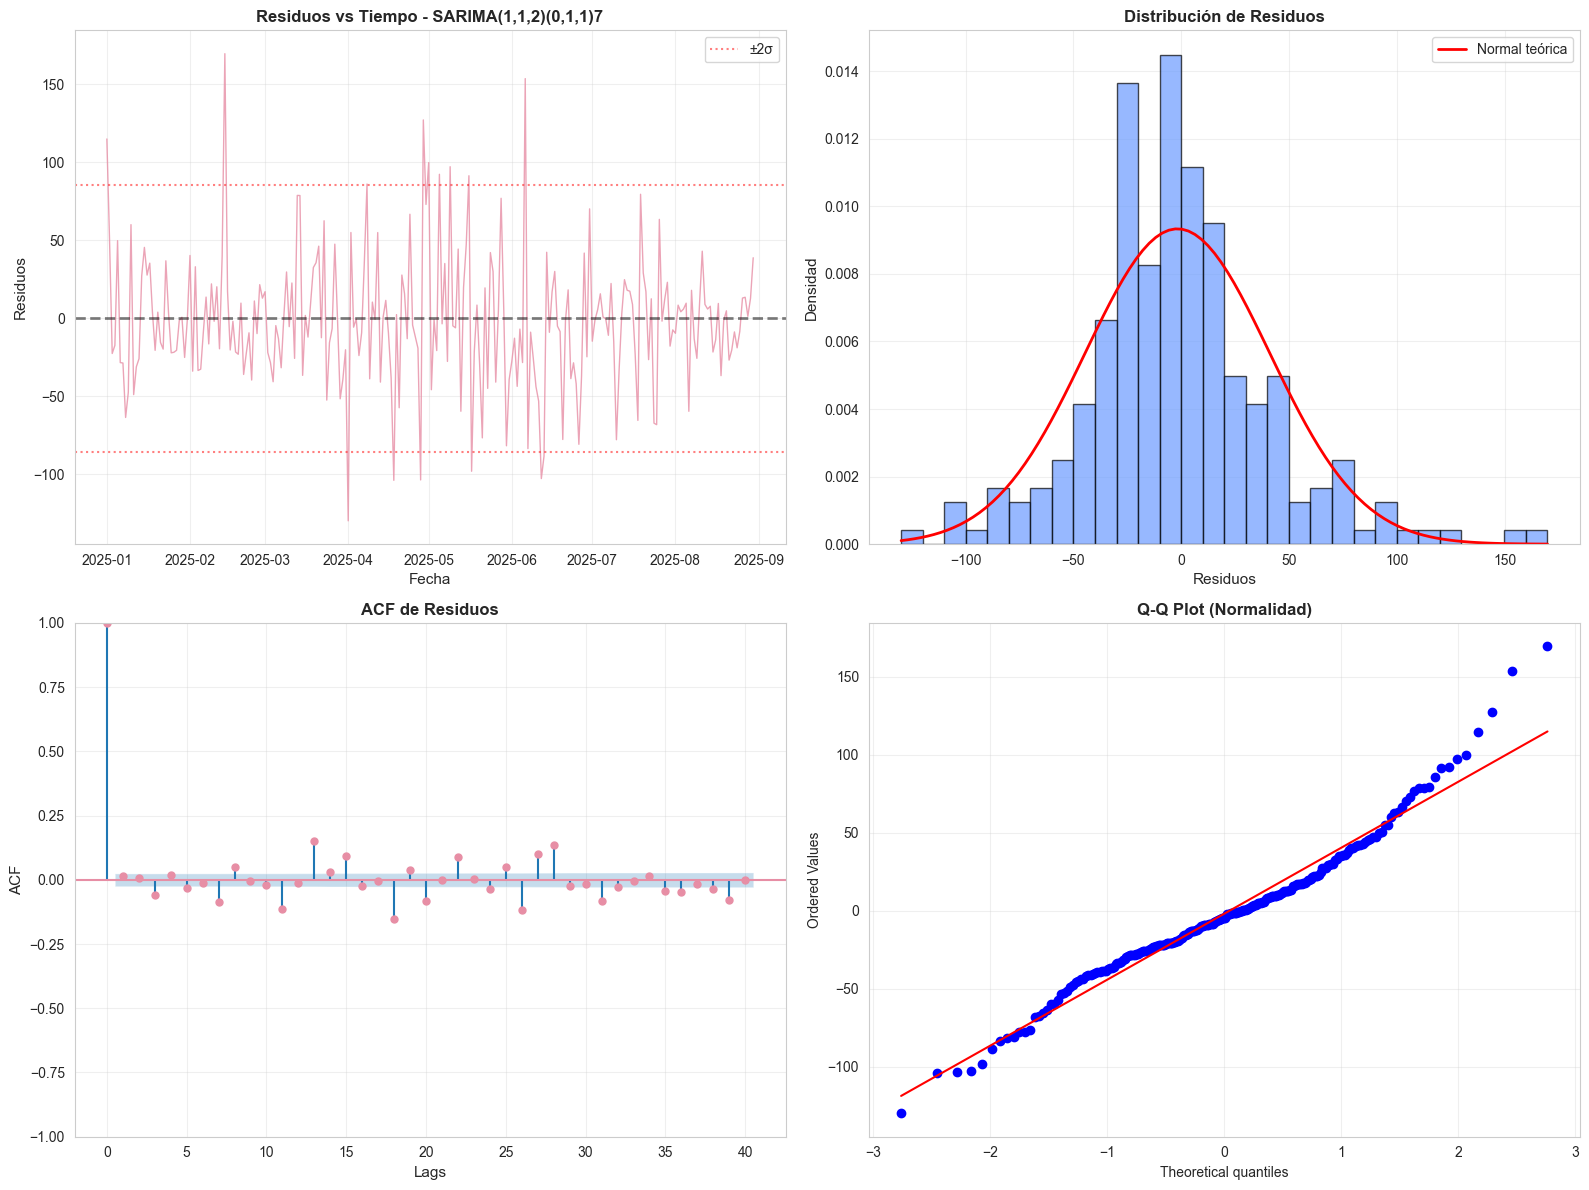


INTERPRETACIÓN VISUAL DE RESIDUOS

✓ Residuos vs Tiempo:
  • Deben oscilar aleatoriamente alrededor de 0
  • No debe haber patrones, tendencias o heterocedasticidad
  • La mayoría debe estar dentro de ±2σ (banda roja)

✓ Histograma:
  • Debe parecerse a una distribución normal (campana)
  • Centrado en 0
  • Sin colas muy largas o múltiples picos

✓ ACF de Residuos:
  • Todos los lags deben estar dentro de las bandas azules
  • Indica que los residuos son ruido blanco (no autocorrelacionados)

✓ Q-Q Plot:
  • Los puntos deben seguir la línea roja diagonal
  • Desviaciones indican no-normalidad



In [16]:
# ============================================================================
# STEP 7: AJUSTAR MODELO ÓPTIMO Y ANÁLISIS DE RESIDUOS
# ============================================================================

print("\n" + "="*80)
print("STEP 7: MODELO ÓPTIMO Y DIAGNÓSTICO DE RESIDUOS")
print("="*80 + "\n")

# Fit the best SARIMA model
print(f"Ajustando modelo: SARIMA({best_p},{best_d},{best_q})({best_P},{best_D},{best_Q}){best_s}")
print("="*80 + "\n")

model_best = SARIMAX(data_og['Ventas'],
                     order=(best_p, best_d, best_q),
                     seasonal_order=(best_P, best_D, best_Q, best_s),
                     enforce_stationarity=False,
                     enforce_invertibility=False)

fitted_best = model_best.fit(disp=False, maxiter=1000, method='lbfgs')

# Display comprehensive summary
print(fitted_best.summary())

print("\n" + "="*80)
print("INTERPRETACIÓN DE COEFICIENTES")
print("="*80 + "\n")

# Extract and display coefficients
params = fitted_best.params
pvalues = fitted_best.pvalues

print("Parámetros estimados y su significancia estadística:")
print("-" * 80)
for param_name, param_value, pvalue in zip(params.index, params.values, pvalues.values):
    significance = "***" if pvalue < 0.001 else "**" if pvalue < 0.01 else "*" if pvalue < 0.05 else "ns"
    print(f"{param_name:20s}: {param_value:8.4f}  (p-value: {pvalue:.4f}) {significance}")

print("\nLeyenda: *** p<0.001, ** p<0.01, * p<0.05, ns = no significativo")

# ============================================================================
# ANÁLISIS DE RESIDUOS
# ============================================================================

residuals = fitted_best.resid

print("\n" + "="*80)
print("ESTADÍSTICAS DE RESIDUOS")
print("="*80 + "\n")

print(f"Media de residuos: {residuals.mean():.6f}")
print(f"  → Debe estar cerca de 0")
print(f"\nDesviación estándar: {residuals.std():.4f}")
print(f"Varianza: {residuals.var():.4f}")
print(f"\nAsimetría (Skewness): {residuals.skew():.4f}")
print(f"  → Debe estar cerca de 0 (distribución simétrica)")
print(f"\nCurtosis: {residuals.kurtosis():.4f}")
print(f"  → Debe estar cerca de 0 (distribución normal tiene curtosis=0)")

# ============================================================================
# VISUALIZACIÓN DE RESIDUOS
# ============================================================================

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Residuos vs Tiempo
axes[0, 0].plot(residuals.index, residuals.values, color='#e78ea5',
                linewidth=1, alpha=0.8)
axes[0, 0].axhline(y=0, color='black', linestyle='--', alpha=0.5, linewidth=2)
axes[0, 0].axhline(y=2*residuals.std(), color='red', linestyle=':',
                   alpha=0.5, label='±2σ')
axes[0, 0].axhline(y=-2*residuals.std(), color='red', linestyle=':', alpha=0.5)
axes[0, 0].set_title(f'Residuos vs Tiempo - SARIMA({best_p},{best_d},{best_q})({best_P},{best_D},{best_Q}){best_s}',
                     fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Fecha', fontsize=11)
axes[0, 0].set_ylabel('Residuos', fontsize=11)
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# Plot 2: Histograma + Curva Normal
axes[0, 1].hist(residuals, bins=30, color='#6b9bff', alpha=0.7,
                edgecolor='black', density=True)

# Overlay normal distribution
mu, sigma = residuals.mean(), residuals.std()
x = np.linspace(residuals.min(), residuals.max(), 100)
axes[0, 1].plot(x, stats.norm.pdf(x, mu, sigma), 'r-',
                linewidth=2, label='Normal teórica')
axes[0, 1].set_title('Distribución de Residuos', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Residuos', fontsize=11)
axes[0, 1].set_ylabel('Densidad', fontsize=11)
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# Plot 3: ACF de residuos
plot_acf(residuals, lags=40, ax=axes[1, 0], color='#e78ea5', alpha=0.7)
axes[1, 0].set_title('ACF de Residuos', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Lags', fontsize=11)
axes[1, 0].set_ylabel('ACF', fontsize=11)
axes[1, 0].grid(alpha=0.3)

# Plot 4: Q-Q Plot
stats.probplot(residuals, dist="norm", plot=axes[1, 1])
axes[1, 1].set_title('Q-Q Plot (Normalidad)', fontsize=12, fontweight='bold')
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("INTERPRETACIÓN VISUAL DE RESIDUOS")
print("="*80)
print("""
✓ Residuos vs Tiempo:
  • Deben oscilar aleatoriamente alrededor de 0
  • No debe haber patrones, tendencias o heterocedasticidad
  • La mayoría debe estar dentro de ±2σ (banda roja)

✓ Histograma:
  • Debe parecerse a una distribución normal (campana)
  • Centrado en 0
  • Sin colas muy largas o múltiples picos

✓ ACF de Residuos:
  • Todos los lags deben estar dentro de las bandas azules
  • Indica que los residuos son ruido blanco (no autocorrelacionados)

✓ Q-Q Plot:
  • Los puntos deben seguir la línea roja diagonal
  • Desviaciones indican no-normalidad
""")

In [20]:
# ============================================================================
# STEP 8: PRUEBAS DE DIAGNÓSTICO DE RESIDUOS
# ============================================================================

print("\n" + "="*80)
print("STEP 8: PRUEBAS ESTADÍSTICAS DE RESIDUOS")
print("="*80 + "\n")

# ============================================================================
# TEST 1: LJUNG-BOX (Autocorrelación - Ruido Blanco)
# ============================================================================

def ljung_box_test_detailed(residuals, lags=20):
    """
    Test de Ljung-Box para autocorrelación en residuos
    H0: Los residuos son ruido blanco (no hay autocorrelación)
    H1: Los residuos tienen autocorrelación
    """
    print("─" * 80)
    print("TEST 1: LJUNG-BOX (Ruido Blanco)")
    print("─" * 80)

    lb_result = acorr_ljungbox(residuals, lags=lags, return_df=True)

    print(f"\nPrimeros {min(10, lags)} lags:")
    print(lb_result.head(10).to_string())

    # Count significant lags
    significant_lags = (lb_result['lb_pvalue'] < 0.05).sum()
    total_lags = len(lb_result)
    pct_significant = (significant_lags / total_lags) * 100

    print(f"\n📊 Resumen:")
    print(f"  Lags significativos (p < 0.05): {significant_lags}/{total_lags} ({pct_significant:.1f}%)")

    # Interpretation
    if pct_significant <= 5:
        print(f"  ✓ EXCELENTE: Los residuos parecen ser RUIDO BLANCO")
        print(f"    Menos del 5% de lags son significativos (esperado por azar)")
    elif pct_significant <= 10:
        print(f"  ✓ BUENO: Los residuos son mayormente ruido blanco")
        print(f"    Ligera autocorrelación residual aceptable")
    else:
        print(f"  ⚠ ADVERTENCIA: Posible autocorrelación residual")
        print(f"    Más del 10% de lags son significativos")
        print(f"    El modelo podría mejorarse")

    return lb_result


# ============================================================================
# TEST 4: HETEROSCEDASTICIDAD (Varianza constante)
# ============================================================================

def heteroscedasticity_test(residuals):
    """
    Test visual y estadístico de heterocedasticidad
    """
    print("\n" + "─" * 80)
    print("TEST 2: HETEROCEDASTICIDAD (Varianza Constante)")
    print("─" * 80)

    # Split residuals into two halves
    n = len(residuals)
    half = n // 2
    first_half = residuals[:half]
    second_half = residuals[half:]

    # Levene's test for equal variances
    levene_stat, levene_pvalue = stats.levene(first_half, second_half)

    print(f"\nTest de Levene:")
    print(f"  Estadístico: {levene_stat:.4f}")
    print(f"  p-value: {levene_pvalue:.6f}")

    if levene_pvalue > 0.05:
        print(f"\n✓ No rechazamos H0 (p = {levene_pvalue:.4f} > 0.05)")
        print(f"  Varianza ES CONSTANTE (homocedasticidad)")
    else:
        print(f"\n✗ Rechazamos H0 (p = {levene_pvalue:.4f} ≤ 0.05)")
        print(f"  Varianza NO es constante (heterocedasticidad)")
        print(f"  Considerar transformaciones o modelos ARCH/GARCH")

    return levene_stat, levene_pvalue

# Execute all tests
lb_result = ljung_box_test_detailed(residuals, lags=20)
#jb_stat, jb_pvalue = jarque_bera_test_detailed(residuals)
#sw_stat, sw_pvalue = shapiro_test_detailed(residuals)
lev_stat, lev_pvalue = heteroscedasticity_test(residuals)

# ============================================================================
# RESUMEN FINAL DE DIAGNÓSTICO
# ============================================================================

print("\n" + "="*80)
print("RESUMEN GENERAL DE DIAGNÓSTICO")
print("="*80 + "\n")

tests_results = {
    'Ljung-Box (Ruido Blanco)': (lb_result['lb_pvalue'] < 0.05).sum() <= 1,
    #'Jarque-Bera (Normalidad)': jb_pvalue > 0.05,
    #'Shapiro-Wilk (Normalidad)': sw_pvalue > 0.05,
    'Levene (Homocedasticidad)': lev_pvalue > 0.05
}

print("Criterio                         Resultado")
print("-" * 80)
for test_name, passed in tests_results.items():
    status = "✓ PASS" if passed else "✗ FAIL"
    print(f"{test_name:35s} {status}")

passed_count = sum(tests_results.values())
total_count = len(tests_results)

print(f"\n{'='*80}")
print(f"Pruebas superadas: {passed_count}/{total_count}")

if passed_count == total_count:
    print("\n🎉 EXCELENTE: El modelo pasa TODAS las pruebas diagnósticas!")
    print("   Los residuos cumplen todos los supuestos.")
    print("   El modelo es VÁLIDO para pronósticos.")
elif passed_count >= total_count - 1:
    print("\n✓ MUY BUENO: El modelo pasa la mayoría de las pruebas.")
    print("   Ligeras desviaciones son aceptables en la práctica.")
    print("   El modelo es VÁLIDO para pronósticos.")
else:
    print("\n⚠ ADVERTENCIA: El modelo no pasa varias pruebas.")
    print("   Considerar:")
    print("   • Transformaciones de datos (log, Box-Cox)")
    print("   • Verificar outliers")
    print("   • Probar modelos alternativos")


STEP 8: PRUEBAS ESTADÍSTICAS DE RESIDUOS

────────────────────────────────────────────────────────────────────────────────
TEST 1: LJUNG-BOX (Ruido Blanco)
────────────────────────────────────────────────────────────────────────────────

Primeros 10 lags:
     lb_stat  lb_pvalue
1   0.059511   0.807270
2   0.072828   0.964241
3   0.993617   0.802796
4   1.064314   0.899892
5   1.316264   0.933249
6   1.363150   0.968062
7   3.265748   0.859379
8   3.886299   0.867233
9   3.894251   0.918234
10  4.008629   0.946957

📊 Resumen:
  Lags significativos (p < 0.05): 0/20 (0.0%)
  ✓ EXCELENTE: Los residuos parecen ser RUIDO BLANCO
    Menos del 5% de lags son significativos (esperado por azar)

────────────────────────────────────────────────────────────────────────────────
TEST 2: HETEROCEDASTICIDAD (Varianza Constante)
────────────────────────────────────────────────────────────────────────────────

Test de Levene:
  Estadístico: 0.0298
  p-value: 0.863099

✓ No rechazamos H0 (p = 0.8631 > 


STEP 9: PRONÓSTICOS A FUTURO - 2 SEMANAS

Modelo final: SARIMA(1,1,2)(0,1,1)7
Horizonte de pronóstico: 14 días (2 semanas)
Intervalo de confianza: 95%

Entrenando modelo final con TODOS los datos...
✓ Modelo ajustado exitosamente
  AIC: 2325.6101
  BIC: 2342.6683
  Log-Likelihood: -1157.8050

Generando pronósticos para 14 días...

PRONÓSTICOS PARA LAS PRÓXIMAS 2 SEMANAS

     Fecha Día_Semana  Pronóstico  Límite_Inferior  Límite_Superior
2025-08-31     Sunday  175.032839        92.272581       257.793098
2025-09-01     Monday  176.762313        88.982976       264.541650
2025-09-02    Tuesday  159.833003        71.054077       248.611929
2025-09-03  Wednesday  161.498136        72.352604       250.643667
2025-09-04   Thursday  208.045051       118.671655       297.418446
2025-09-05     Friday  208.084444       118.521486       297.647403
2025-09-06   Saturday  182.892916        93.152333       272.633498
2025-09-07     Sunday  160.249977        64.233051       256.266902
2025-09-08   

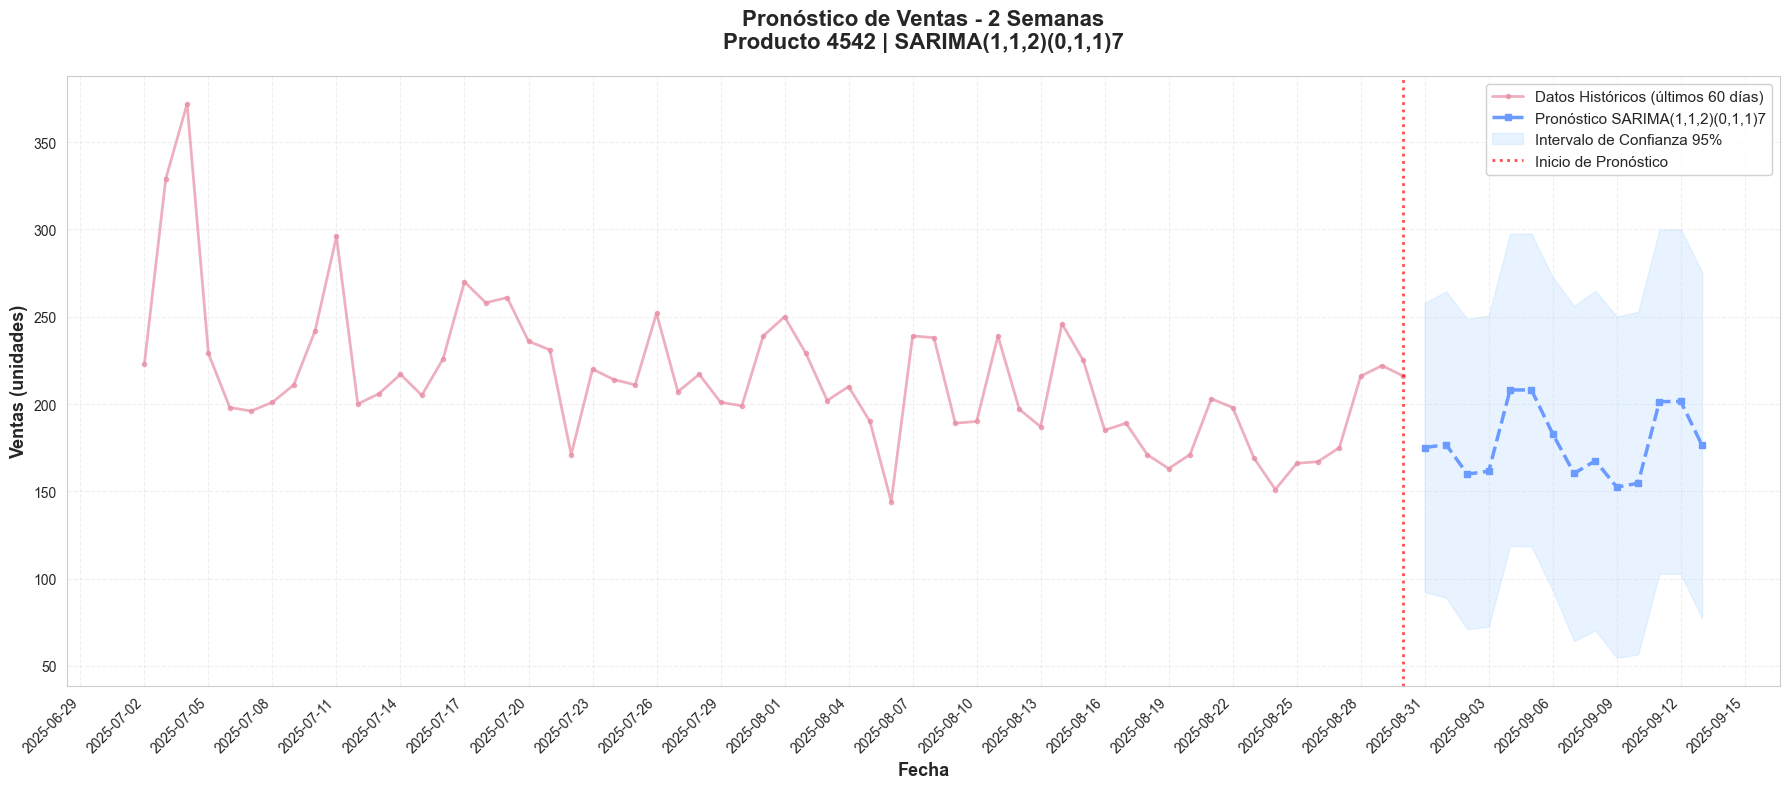

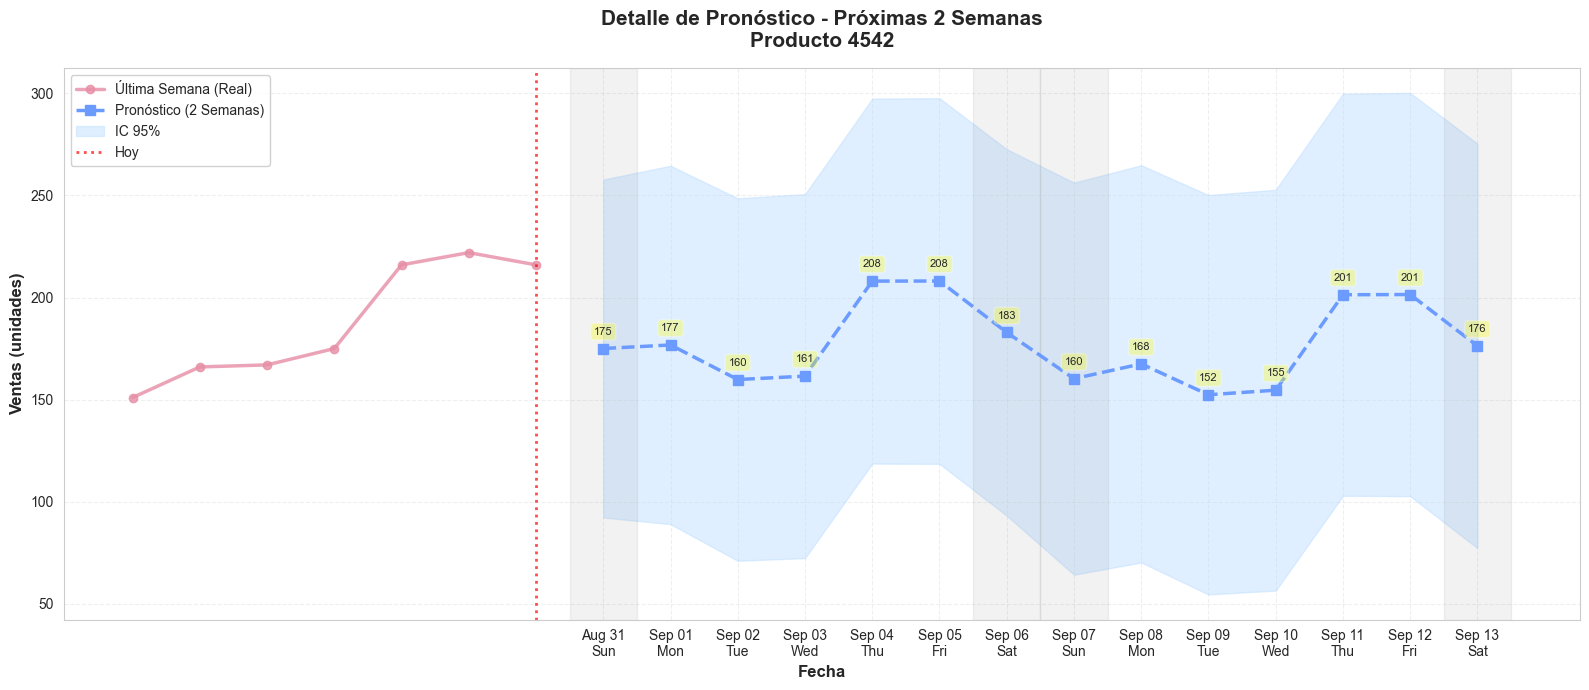

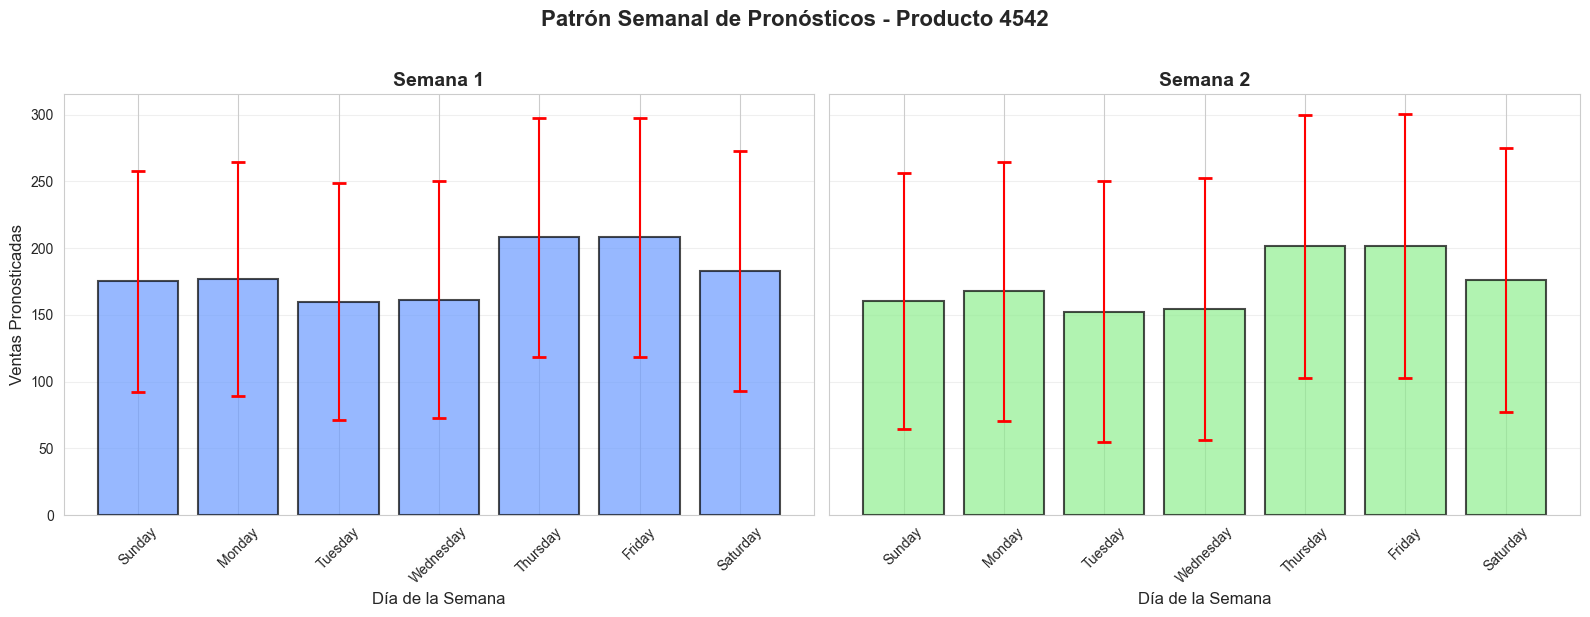


ESTADÍSTICAS DE PRONÓSTICO

Pronóstico promedio (2 semanas): 177.57 unidades/día
Pronóstico mínimo: 152.37 unidades
Pronóstico máximo: 208.08 unidades
Desviación estándar: 19.94 unidades

Demanda total esperada (2 semanas): 2486 unidades
Rango total con IC 95%: [1183, 3789] unidades

Comparación semanal:
  Semana 1 (días 1-7): 1272 unidades
  Semana 2 (días 8-14): 1214 unidades
  Diferencia: 58 unidades (-4.6%)

Pronóstico promedio por día de la semana:
  Friday      : 204.8 unidades
  Thursday    : 204.7 unidades
  Saturday    : 179.6 unidades
  Monday      : 172.1 unidades
  Sunday      : 167.6 unidades
  Wednesday   : 158.1 unidades
  Tuesday     : 156.1 unidades

PRONÓSTICO COMPLETADO


In [21]:
# ============================================================================
# FORECASTING - PRÓXIMAS 2 SEMANAS (14 DÍAS)
# ============================================================================

print("\n" + "="*80)
print("STEP 9: PRONÓSTICOS A FUTURO - 2 SEMANAS")
print("="*80 + "\n")

# Parameters
forecast_horizon = 14  # 2 weeks
confidence_level = 0.95  # 95% confidence interval

print(f"Modelo final: SARIMA({best_p},{best_d},{best_q})({best_P},{best_D},{best_Q}){best_s}")
print(f"Horizonte de pronóstico: {forecast_horizon} días (2 semanas)")
print(f"Intervalo de confianza: {confidence_level*100:.0f}%")

# Train final model on ALL data
print("\nEntrenando modelo final con TODOS los datos...")
model_final = SARIMAX(data_og['Ventas'],
                     order=(best_p, best_d, best_q),
                     seasonal_order=(best_P, best_D, best_Q, best_s),
                     enforce_stationarity=False,
                     enforce_invertibility=False)

fitted_final = model_final.fit(disp=False, maxiter=1000, method='lbfgs')

print("✓ Modelo ajustado exitosamente")
print(f"  AIC: {fitted_final.aic:.4f}")
print(f"  BIC: {fitted_final.bic:.4f}")
print(f"  Log-Likelihood: {fitted_final.llf:.4f}")

# Generate forecasts
print(f"\nGenerando pronósticos para {forecast_horizon} días...")
forecast_obj = fitted_final.get_forecast(steps=forecast_horizon)

# Extract forecast components
forecast_mean = forecast_obj.predicted_mean
forecast_ci = forecast_obj.conf_int(alpha=1-confidence_level)

# Create forecast dates
last_date = data_og.index[-1]
forecast_dates = pd.date_range(
    start=last_date + pd.Timedelta(days=1),
    periods=forecast_horizon,
    freq='D'
)

# Create forecast DataFrame
forecast_df = pd.DataFrame({
    'Fecha': forecast_dates,
    'Pronóstico': forecast_mean.values,
    'Límite_Inferior': forecast_ci.iloc[:, 0].values,
    'Límite_Superior': forecast_ci.iloc[:, 1].values,
    'Producto_ID': PRODUCT_ID
})

# Add day of week for context
forecast_df['Día_Semana'] = forecast_df['Fecha'].dt.day_name()

print("\n" + "="*80)
print("PRONÓSTICOS PARA LAS PRÓXIMAS 2 SEMANAS")
print("="*80 + "\n")
print(forecast_df[['Fecha', 'Día_Semana', 'Pronóstico',
                   'Límite_Inferior', 'Límite_Superior']].to_string(index=False))

# ============================================================================
# VISUALIZATION 1: Complete Time Series with Forecasts
# ============================================================================

print("\n\nGenerando visualizaciones...")

fig, ax = plt.subplots(figsize=(18, 8))

# Historical data (last 60 days for better visualization)
last_60_days = data_og.tail(60)

# Plot historical data
ax.plot(last_60_days.index, last_60_days['Ventas'],
        color='#e78ea5', linewidth=2, label='Datos Históricos (últimos 60 días)',
        marker='o', markersize=3, alpha=0.7)

# Plot forecasts
ax.plot(forecast_df['Fecha'], forecast_df['Pronóstico'],
        color='#6b9bff', linewidth=2.5, linestyle='--',
        label=f'Pronóstico SARIMA({best_p},{best_d},{best_q})({best_P},{best_D},{best_Q}){best_s}',
        marker='s', markersize=5)

# Plot confidence intervals
ax.fill_between(forecast_df['Fecha'],
                forecast_df['Límite_Inferior'],
                forecast_df['Límite_Superior'],
                color='#b3d9ff', alpha=0.3,
                label=f'Intervalo de Confianza {confidence_level*100:.0f}%')

# Add vertical line separating history from forecast
ax.axvline(x=last_date, color='red', linestyle=':',
           linewidth=2, alpha=0.7, label='Inicio de Pronóstico')

# Formatting
ax.set_title(f'Pronóstico de Ventas - 2 Semanas\nProducto {PRODUCT_ID} | '
             f'SARIMA({best_p},{best_d},{best_q})({best_P},{best_D},{best_Q}){best_s}',
             fontsize=16, fontweight='bold', pad=20)
ax.set_xlabel('Fecha', fontsize=13, fontweight='bold')
ax.set_ylabel('Ventas (unidades)', fontsize=13, fontweight='bold')
ax.legend(loc='best', fontsize=11, framealpha=0.9)
ax.grid(True, alpha=0.3, linestyle='--')

# Format x-axis dates
ax.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m-%d'))
ax.xaxis.set_major_locator(plt.matplotlib.dates.DayLocator(interval=3))
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

# ============================================================================
# VISUALIZATION 2: Forecast Detail (Only next 2 weeks)
# ============================================================================

fig, ax = plt.subplots(figsize=(16, 7))

# Last 7 days of historical data (for context)
last_week = data_og.tail(7)
ax.plot(last_week.index, last_week['Ventas'],
        color='#e78ea5', linewidth=2.5,
        label='Última Semana (Real)',
        marker='o', markersize=6, alpha=0.8)

# Forecast
ax.plot(forecast_df['Fecha'], forecast_df['Pronóstico'],
        color='#6b9bff', linewidth=2.5, linestyle='--',
        label='Pronóstico (2 Semanas)',
        marker='s', markersize=7)

# Confidence intervals
ax.fill_between(forecast_df['Fecha'],
                forecast_df['Límite_Inferior'],
                forecast_df['Límite_Superior'],
                color='#b3d9ff', alpha=0.4,
                label=f'IC {confidence_level*100:.0f}%')

# Add point labels for forecasts
for idx, row in forecast_df.iterrows():
    ax.annotate(f"{row['Pronóstico']:.0f}",
                xy=(row['Fecha'], row['Pronóstico']),
                xytext=(0, 10), textcoords='offset points',
                ha='center', fontsize=8,
                bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.3))

# Mark weekends
for date in forecast_df['Fecha']:
    if date.dayofweek >= 5:  # Saturday=5, Sunday=6
        ax.axvspan(date - pd.Timedelta(hours=12),
                  date + pd.Timedelta(hours=12),
                  color='gray', alpha=0.1)

# Vertical line at transition
ax.axvline(x=last_date, color='red', linestyle=':',
           linewidth=2, alpha=0.7, label='Hoy')

# Formatting
ax.set_title(f'Detalle de Pronóstico - Próximas 2 Semanas\n'
             f'Producto {PRODUCT_ID}',
             fontsize=15, fontweight='bold', pad=15)
ax.set_xlabel('Fecha', fontsize=12, fontweight='bold')
ax.set_ylabel('Ventas (unidades)', fontsize=12, fontweight='bold')
ax.legend(loc='best', fontsize=10, framealpha=0.9)
ax.grid(True, alpha=0.3, linestyle='--')

# Format x-axis
ax.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%b %d\n%a'))
plt.xticks(forecast_df['Fecha'], rotation=0)

plt.tight_layout()
plt.show()

# ============================================================================
# VISUALIZATION 3: Weekly Pattern Analysis
# ============================================================================

# Add week number and day of week
forecast_df['Semana'] = ['Semana 1' if i < 7 else 'Semana 2'
                         for i in range(len(forecast_df))]
forecast_df['Día_Semana_Num'] = forecast_df['Fecha'].dt.dayofweek

# Group by week
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

week1 = forecast_df[forecast_df['Semana'] == 'Semana 1']
week2 = forecast_df[forecast_df['Semana'] == 'Semana 2']

# Week 1
axes[0].bar(week1['Día_Semana'], week1['Pronóstico'],
           color='#6b9bff', alpha=0.7, edgecolor='black', linewidth=1.5)
axes[0].errorbar(week1['Día_Semana'], week1['Pronóstico'],
                yerr=[week1['Pronóstico'] - week1['Límite_Inferior'],
                      week1['Límite_Superior'] - week1['Pronóstico']],
                fmt='none', ecolor='red', capsize=5, capthick=2)
axes[0].set_title('Semana 1', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Día de la Semana', fontsize=12)
axes[0].set_ylabel('Ventas Pronosticadas', fontsize=12)
axes[0].grid(axis='y', alpha=0.3)
axes[0].tick_params(axis='x', rotation=45)

# Week 2
axes[1].bar(week2['Día_Semana'], week2['Pronóstico'],
           color='#90ee90', alpha=0.7, edgecolor='black', linewidth=1.5)
axes[1].errorbar(week2['Día_Semana'], week2['Pronóstico'],
                yerr=[week2['Pronóstico'] - week2['Límite_Inferior'],
                      week2['Límite_Superior'] - week2['Pronóstico']],
                fmt='none', ecolor='red', capsize=5, capthick=2)
axes[1].set_title('Semana 2', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Día de la Semana', fontsize=12)
axes[1].grid(axis='y', alpha=0.3)
axes[1].tick_params(axis='x', rotation=45)

fig.suptitle(f'Patrón Semanal de Pronósticos - Producto {PRODUCT_ID}',
             fontsize=16, fontweight='bold', y=1.02)

plt.tight_layout()
plt.show()

# ============================================================================
# SUMMARY STATISTICS
# ============================================================================

print("\n" + "="*80)
print("ESTADÍSTICAS DE PRONÓSTICO")
print("="*80 + "\n")

print(f"Pronóstico promedio (2 semanas): {forecast_df['Pronóstico'].mean():.2f} unidades/día")
print(f"Pronóstico mínimo: {forecast_df['Pronóstico'].min():.2f} unidades")
print(f"Pronóstico máximo: {forecast_df['Pronóstico'].max():.2f} unidades")
print(f"Desviación estándar: {forecast_df['Pronóstico'].std():.2f} unidades")

print(f"\nDemanda total esperada (2 semanas): {forecast_df['Pronóstico'].sum():.0f} unidades")
print(f"Rango total con IC 95%: [{forecast_df['Límite_Inferior'].sum():.0f}, "
      f"{forecast_df['Límite_Superior'].sum():.0f}] unidades")

# Weekly comparison
week1_total = week1['Pronóstico'].sum()
week2_total = week2['Pronóstico'].sum()

print(f"\nComparación semanal:")
print(f"  Semana 1 (días 1-7): {week1_total:.0f} unidades")
print(f"  Semana 2 (días 8-14): {week2_total:.0f} unidades")
print(f"  Diferencia: {abs(week2_total - week1_total):.0f} unidades "
      f"({((week2_total - week1_total)/week1_total * 100):.1f}%)")

# Day of week analysis
print("\nPronóstico promedio por día de la semana:")
day_avg = forecast_df.groupby('Día_Semana')['Pronóstico'].mean().sort_values(ascending=False)
for day, value in day_avg.items():
    print(f"  {day:12s}: {value:.1f} unidades")

# ============================================================================
# SAVE RESULTS
# ============================================================================

# Save to CSV
#output_filename = f'/home/claude/forecast_producto_{PRODUCT_ID}_2semanas.csv'
#forecast_df.to_csv(output_filename, index=False)

#print(f"\n✓ Pronósticos guardados en: {output_filename}")

print("\n" + "="*80)
print("PRONÓSTICO COMPLETADO")
print("="*80)

In [22]:
# ============================================================================
# BATCH FORECASTING: APPLY SARIMA(1,1,2)(0,1,1)₇ TO ALL PRODUCTS
# ============================================================================

print("\n" + "="*80)
print("PRONÓSTICO BATCH - TODOS LOS PRODUCTOS")
print("="*80 + "\n")

print(f"Modelo base: SARIMA(1,1,2)(0,1,1)₇")
print(f"Productos a procesar: {len(product_ids)}")
print(f"Horizonte de pronóstico: 14 días (2 semanas)")
print("\n" + "="*80 + "\n")

# Storage for results
all_forecasts = []
all_diagnostics = []
all_models_summary = []
failed_products = []

# Model parameters (from best model for product 4542)
p, d, q = 1, 1, 2
P, D, Q, s = 0, 1, 1, 7
forecast_horizon = 14

# Function to process one product
def forecast_product(df, product_id, p, d, q, P, D, Q, s, forecast_horizon=14):
    """
    Fit SARIMA model and generate forecasts for a single product
    """
    try:
        # Prepare time series
        data = prepare_time_series(df, product_id, freq='D')

        # Check if we have enough data
        min_obs = 30  # Minimum observations needed
        if len(data) < min_obs:
            print(f"⚠ Producto {product_id}: Datos insuficientes ({len(data)} obs)")
            return None, None, None, "Datos insuficientes"

        print(f"\nProcesando Producto {product_id}...")
        print(f"  Observaciones: {len(data)}")
        print(f"  Rango: {data.index.min().date()} a {data.index.max().date()}")

        # Fit model
        model = SARIMAX(data['Ventas'],
                       order=(p, d, q),
                       seasonal_order=(P, D, Q, s),
                       enforce_stationarity=False,
                       enforce_invertibility=False)

        fitted = model.fit(disp=False, maxiter=1000, method='lbfgs')

        # Get diagnostics
        aic = fitted.aic
        bic = fitted.bic
        llf = fitted.llf

        # Residual analysis
        residuals = fitted.resid
        res_mean = residuals.mean()
        res_std = residuals.std()

        # Ljung-Box test (quick check)
        lb_result = acorr_ljungbox(residuals, lags=20, return_df=True)
        lb_pvalues_sig = (lb_result['lb_pvalue'] < 0.05).sum()

        # Generate forecasts
        forecast_obj = fitted.get_forecast(steps=forecast_horizon)
        forecast_mean = forecast_obj.predicted_mean
        forecast_ci = forecast_obj.conf_int(alpha=0.05)

        # Create forecast dates
        last_date = data.index[-1]
        forecast_dates = pd.date_range(
            start=last_date + pd.Timedelta(days=1),
            periods=forecast_horizon,
            freq='D'
        )

        # Create forecast DataFrame
        forecast_df = pd.DataFrame({
            'Producto_ID': product_id,
            'Fecha': forecast_dates,
            'Pronóstico': forecast_mean.values,
            'Límite_Inferior': forecast_ci.iloc[:, 0].values,
            'Límite_Superior': forecast_ci.iloc[:, 1].values
        })

        # Diagnostics summary
        diagnostics = {
            'Producto_ID': product_id,
            'N_Obs': len(data),
            'AIC': aic,
            'BIC': bic,
            'Log_Likelihood': llf,
            'Res_Mean': res_mean,
            'Res_Std': res_std,
            'LB_Sig_Lags': lb_pvalues_sig,
            'LB_Pass': 'Sí' if lb_pvalues_sig <= 1 else 'No',
            'Forecast_Mean': forecast_mean.mean(),
            'Forecast_Total': forecast_mean.sum()
        }

        # Model summary
        summary = {
            'Producto_ID': product_id,
            'Modelo': f'SARIMA({p},{d},{q})({P},{D},{Q}){s}',
            'AIC': aic,
            'MAPE_LB_Pass': 'Sí' if lb_pvalues_sig <= 1 else 'No',
            'Status': 'Exitoso'
        }

        print(f"  ✓ Modelo ajustado - AIC: {aic:.2f}")
        print(f"  ✓ Pronóstico promedio: {forecast_mean.mean():.1f} unidades/día")
        print(f"  ✓ Ljung-Box: {lb_pvalues_sig}/20 lags significativos")

        return forecast_df, diagnostics, summary, None

    except Exception as e:
        print(f"  ✗ ERROR en Producto {product_id}: {str(e)}")
        summary = {
            'Producto_ID': product_id,
            'Modelo': f'SARIMA({p},{d},{q})({P},{D},{Q}){s}',
            'AIC': np.nan,
            'MAPE_LB_Pass': 'N/A',
            'Status': 'Fallido'
        }
        return None, None, summary, str(e)

# Process all products
print("Iniciando procesamiento batch...\n")
print("="*80)

for product_id in product_ids:
    forecast_df, diagnostics, summary, error = forecast_product(
        df, product_id, p, d, q, P, D, Q, s, forecast_horizon
    )

    if forecast_df is not None:
        all_forecasts.append(forecast_df)
        all_diagnostics.append(diagnostics)
        all_models_summary.append(summary)
    else:
        all_models_summary.append(summary)
        failed_products.append((product_id, error))

print("\n" + "="*80)
print("PROCESAMIENTO COMPLETADO")
print("="*80 + "\n")

# Consolidate results
if len(all_forecasts) > 0:
    forecasts_combined = pd.concat(all_forecasts, ignore_index=True)
    diagnostics_df = pd.DataFrame(all_diagnostics)
    summary_df = pd.DataFrame(all_models_summary)

    successful = len(all_forecasts)
    failed = len(failed_products)

    print(f"✓ Productos procesados exitosamente: {successful}/{len(product_ids)}")
    if failed > 0:
        print(f"✗ Productos fallidos: {failed}")
        for pid, err in failed_products:
            print(f"    - Producto {pid}: {err}")

    print("\n" + "="*80)
    print("RESUMEN DE MODELOS")
    print("="*80 + "\n")
    print(summary_df.to_string(index=False))

    print("\n" + "="*80)
    print("DIAGNÓSTICOS DETALLADOS")
    print("="*80 + "\n")
    display_cols = ['Producto_ID', 'N_Obs', 'AIC', 'Res_Mean', 'Res_Std',
                    'LB_Sig_Lags', 'LB_Pass', 'Forecast_Mean', 'Forecast_Total']
    print(diagnostics_df[display_cols].to_string(index=False))

else:
    print("✗ No se pudieron procesar productos exitosamente")


PRONÓSTICO BATCH - TODOS LOS PRODUCTOS

Modelo base: SARIMA(1,1,2)(0,1,1)₇
Productos a procesar: 10
Horizonte de pronóstico: 14 días (2 semanas)


Iniciando procesamiento batch...


Procesando Producto 4542...
  Observaciones: 242
  Rango: 2025-01-01 a 2025-08-30
  ✓ Modelo ajustado - AIC: 2325.61
  ✓ Pronóstico promedio: 177.6 unidades/día
  ✓ Ljung-Box: 0/20 lags significativos

Procesando Producto 4561...
  Observaciones: 242
  Rango: 2025-01-01 a 2025-08-30
  ✓ Modelo ajustado - AIC: 2245.63
  ✓ Pronóstico promedio: 262.2 unidades/día
  ✓ Ljung-Box: 9/20 lags significativos

Procesando Producto 4568...
  Observaciones: 242
  Rango: 2025-01-01 a 2025-08-30
  ✓ Modelo ajustado - AIC: 2030.56
  ✓ Pronóstico promedio: 155.1 unidades/día
  ✓ Ljung-Box: 0/20 lags significativos

Procesando Producto 4602...
  Observaciones: 242
  Rango: 2025-01-01 a 2025-08-30
  ✓ Modelo ajustado - AIC: 1948.14
  ✓ Pronóstico promedio: 82.3 unidades/día
  ✓ Ljung-Box: 0/20 lags significativos

Procesando



Generando visualizaciones comparativas...


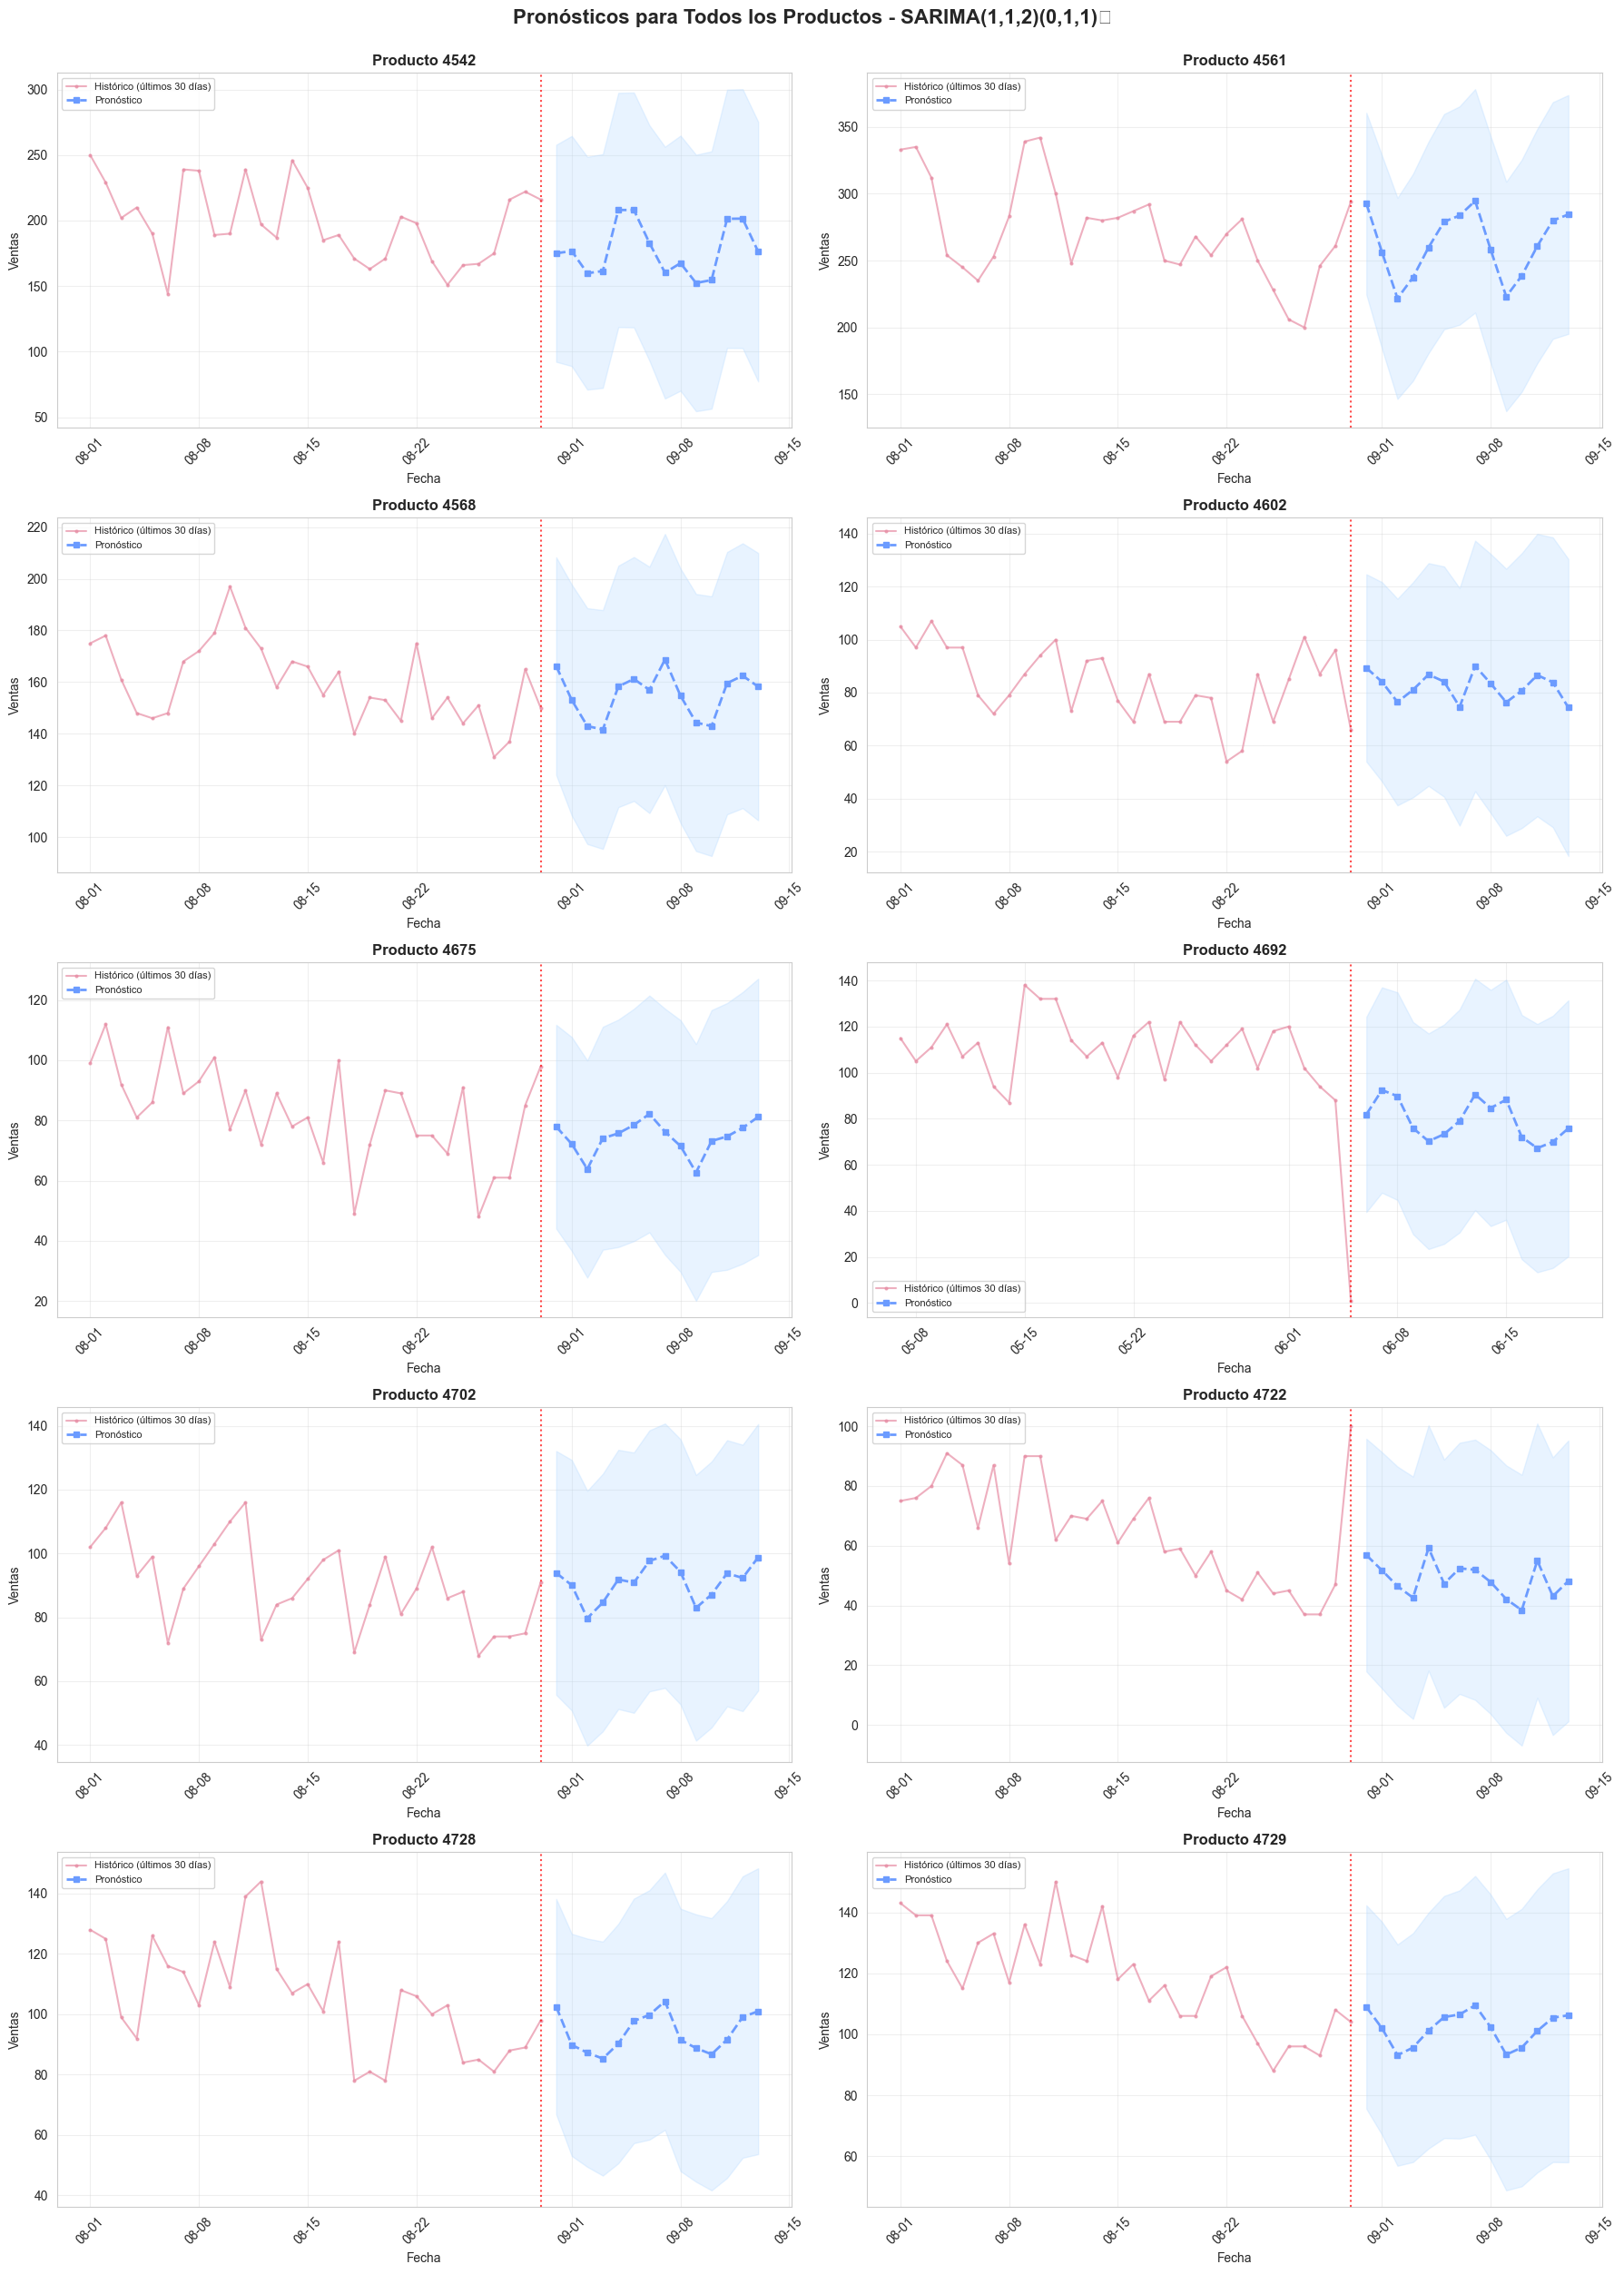

In [23]:
# ============================================================================
# VISUALIZATION 1: All Products Forecasts - Small Multiples
# ============================================================================

if len(all_forecasts) > 0:
    print("\n\nGenerando visualizaciones comparativas...")

    # Small multiples: One plot per product
    n_products = len(all_forecasts)
    n_cols = 2
    n_rows = int(np.ceil(n_products / n_cols))

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 5*n_rows))
    axes = axes.flatten() if n_products > 1 else [axes]

    for idx, forecast_df in enumerate(all_forecasts):
        ax = axes[idx]
        product_id = forecast_df['Producto_ID'].iloc[0]

        # Get historical data for this product
        data_hist = prepare_time_series(df, product_id, freq='D').tail(30)

        # Plot historical
        ax.plot(data_hist.index, data_hist['Ventas'],
               color='#e78ea5', linewidth=1.5, label='Histórico (últimos 30 días)',
               marker='o', markersize=2, alpha=0.7)

        # Plot forecast
        ax.plot(forecast_df['Fecha'], forecast_df['Pronóstico'],
               color='#6b9bff', linewidth=2, linestyle='--',
               label='Pronóstico', marker='s', markersize=4)

        # Confidence interval
        ax.fill_between(forecast_df['Fecha'],
                       forecast_df['Límite_Inferior'],
                       forecast_df['Límite_Superior'],
                       color='#b3d9ff', alpha=0.3)

        # Vertical line
        ax.axvline(x=data_hist.index[-1], color='red',
                  linestyle=':', linewidth=1.5, alpha=0.7)

        # Formatting
        ax.set_title(f'Producto {product_id}', fontsize=12, fontweight='bold')
        ax.set_xlabel('Fecha', fontsize=10)
        ax.set_ylabel('Ventas', fontsize=10)
        ax.legend(fontsize=8, loc='best')
        ax.grid(alpha=0.3)
        ax.tick_params(axis='x', rotation=45)

        # Format x-axis
        ax.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%m-%d'))

    # Hide extra subplots
    for idx in range(n_products, len(axes)):
        axes[idx].axis('off')

    fig.suptitle('Pronósticos para Todos los Productos - SARIMA(1,1,2)(0,1,1)₇',
                 fontsize=16, fontweight='bold', y=1.00)
    plt.tight_layout()
    plt.show()


CREANDO DASHBOARD CONSOLIDADO - FIGURA ÚNICA

Preparando datos...
  ✓ Producto 4542: 242 obs históricas, 14 días pronóstico
  ✓ Producto 4561: 242 obs históricas, 14 días pronóstico
  ✓ Producto 4602: 242 obs históricas, 14 días pronóstico
  ✓ Producto 4702: 242 obs históricas, 14 días pronóstico
  ✓ Producto 4728: 242 obs históricas, 14 días pronóstico

Generando visualizaciones...
✓ Plot 1/6: Producto 4542 - Serie Temporal Completa
✓ Plot 2/6: Producto 4542 - Detalle de Pronóstico
✓ Plot 3/6: Producto 4561
✓ Plot 4/6: Producto 4602
✓ Plot 5/6: Producto 4702
✓ Plot 6/6: Producto 4728

✓ Dashboard completo generado



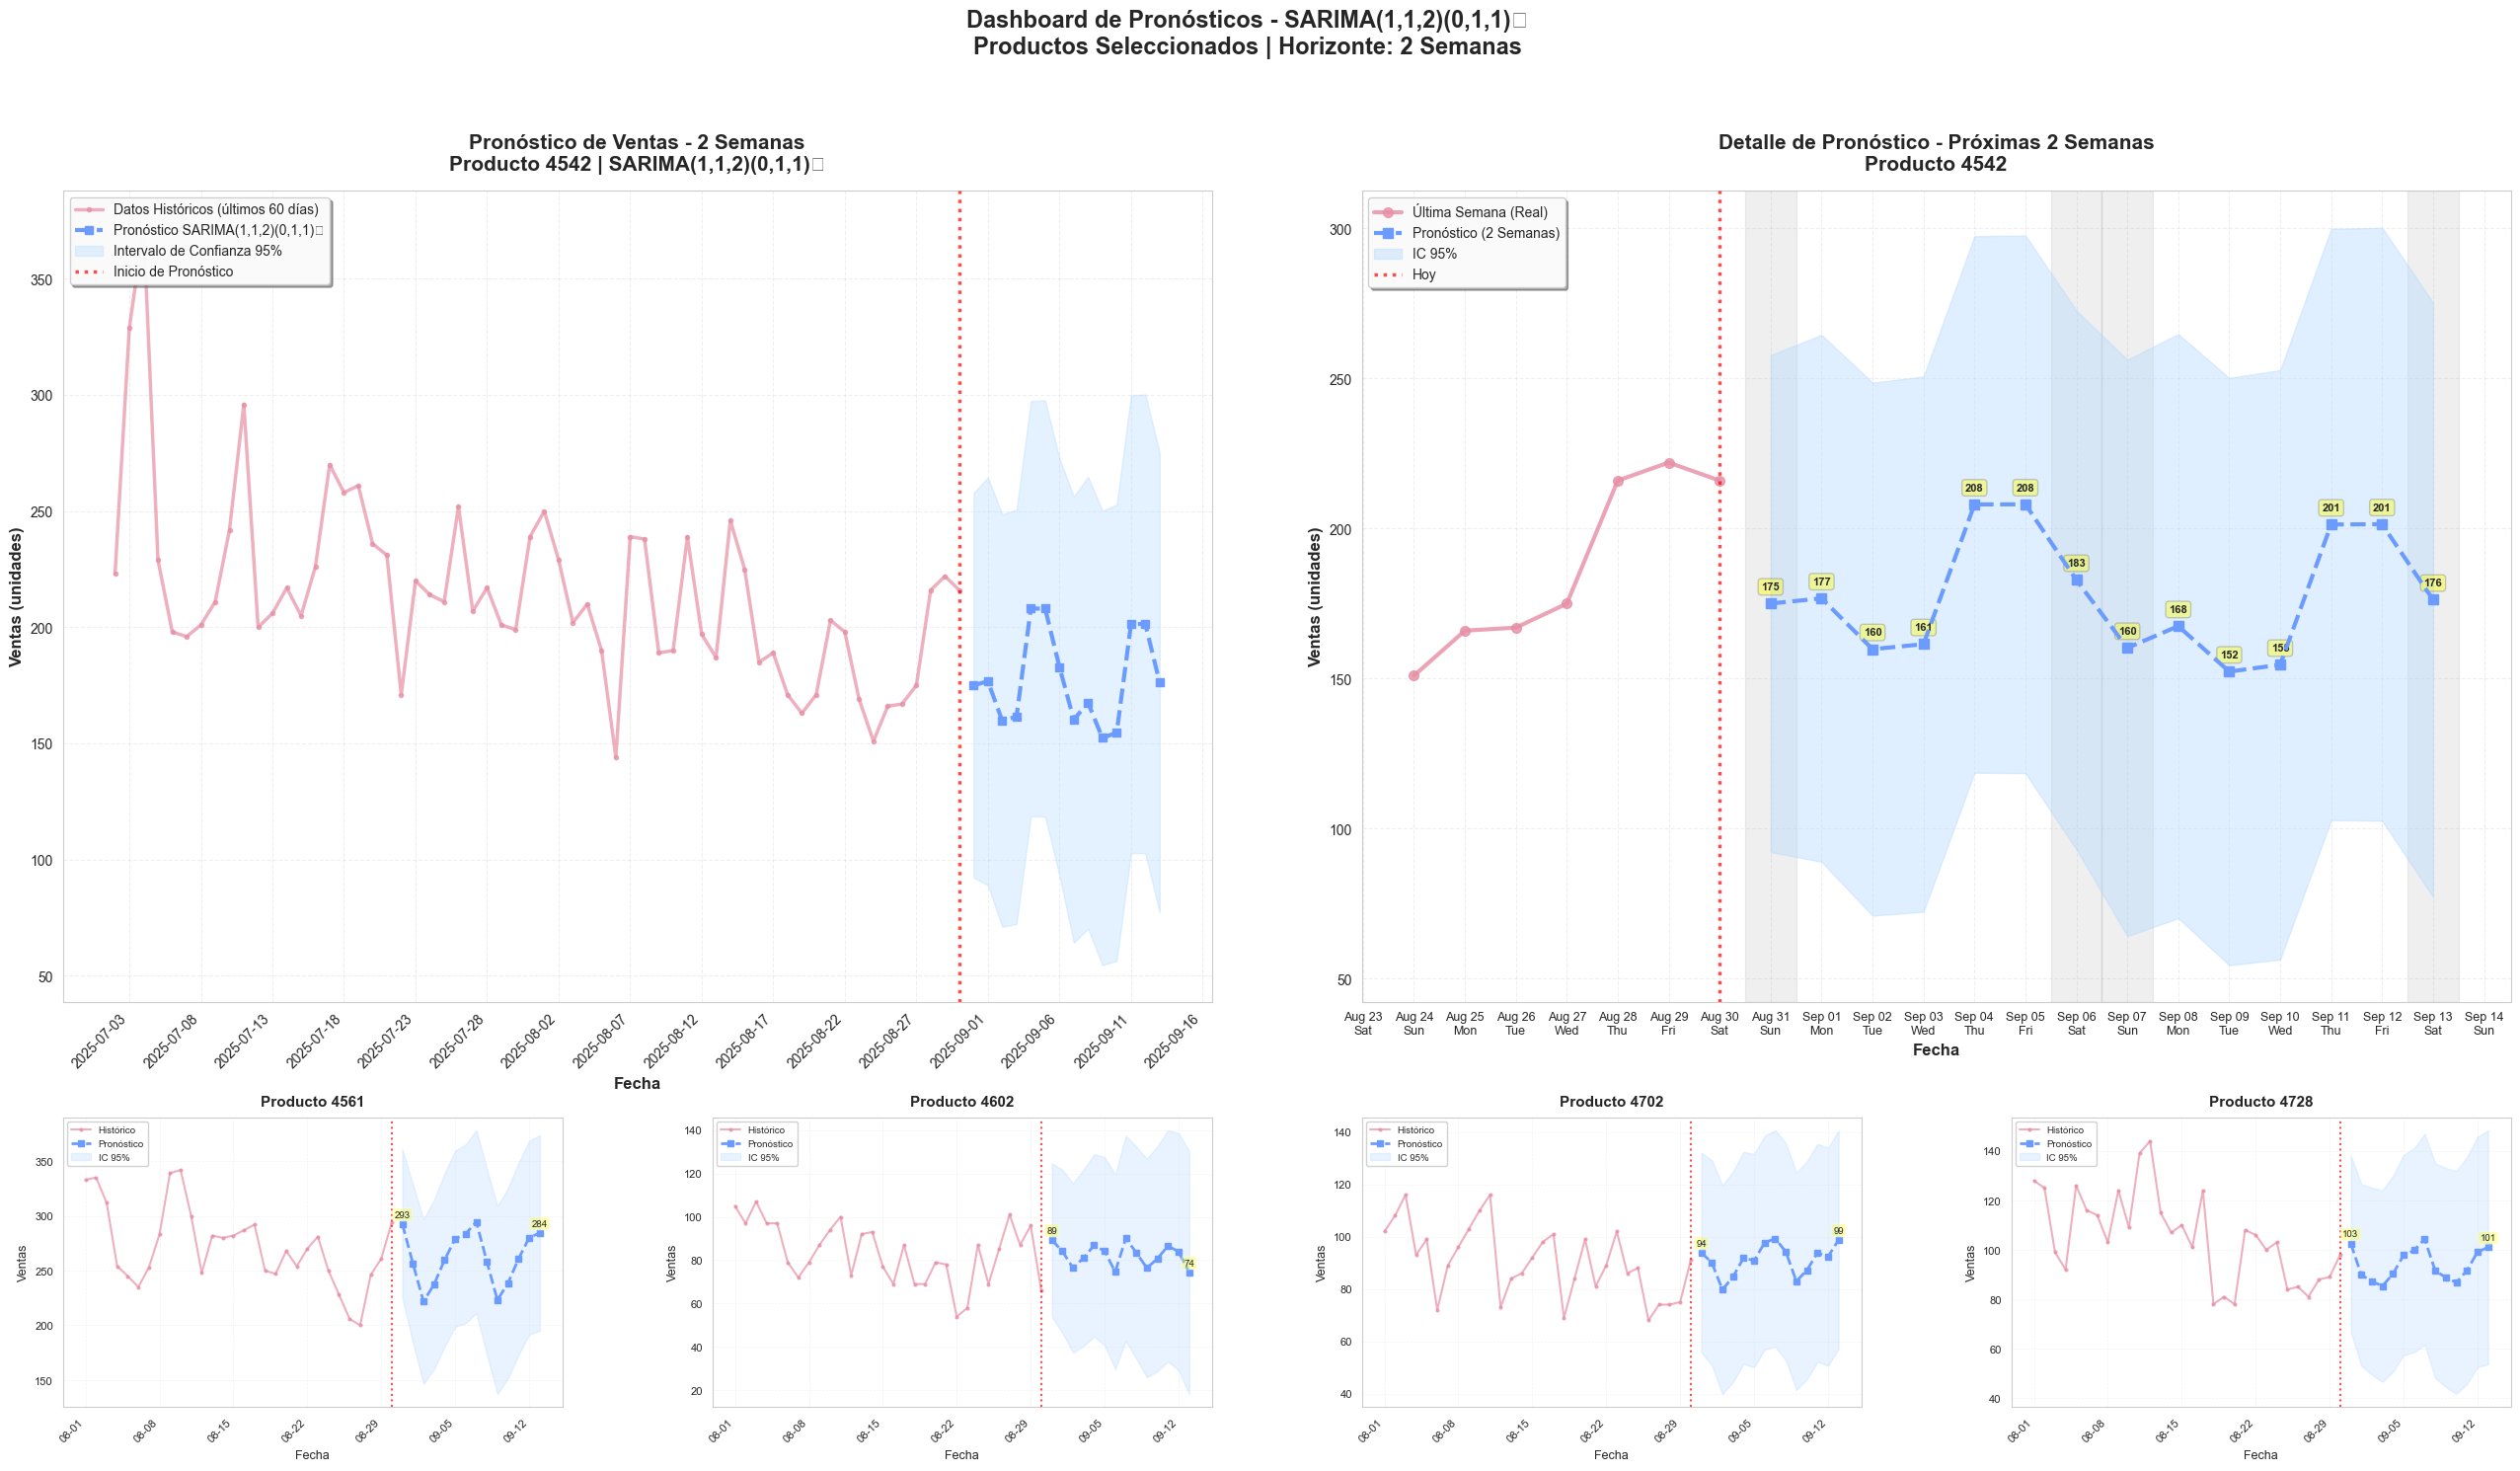

✓ Figura guardada: dashboard_pronosticos_consolidado.png

DASHBOARD COMPLETADO


In [28]:
# ============================================================================
# SINGLE FIGURE: 2 LARGE PLOTS (4542) + 4 SMALL PLOTS (OTHER PRODUCTS)
# ============================================================================

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.gridspec import GridSpec

print("\n" + "="*80)
print("CREANDO DASHBOARD CONSOLIDADO - FIGURA ÚNICA")
print("="*80 + "\n")

# Define products
main_product = 4542
other_products = [4561, 4602, 4702, 4728]

# Prepare data for all products
forecast_data = {}
historical_data = {}

print("Preparando datos...")
for product_id in [main_product] + other_products:
    # Historical data
    hist = prepare_time_series(df, product_id, freq='D')
    historical_data[product_id] = hist

    # Get forecast from combined forecasts
    if product_id in forecasts_combined['Producto_ID'].values:
        forecast = forecasts_combined[forecasts_combined['Producto_ID'] == product_id].copy()
        forecast['Fecha'] = pd.to_datetime(forecast['Fecha'])
        forecast_data[product_id] = forecast
        print(f"  ✓ Producto {product_id}: {len(hist)} obs históricas, 14 días pronóstico")
    else:
        print(f"  ⚠ Producto {product_id}: No hay pronóstico disponible")

# ============================================================================
# CREATE FIGURE WITH CUSTOM LAYOUT
# ============================================================================

# Create figure
fig = plt.figure(figsize=(32, 16))

# Create GridSpec: 2 rows, with top row taller than bottom
# Top row: 2 columns (for the 2 large 4542 plots)
# Bottom row: 4 columns (for the 4 small plots)
gs = GridSpec(3, 4, figure=fig,
              height_ratios=[1.2, 1.2, 1],  # Top 2 rows larger, bottom smaller
              hspace=0.35, wspace=0.3)

# Color scheme
color_hist = '#e78ea5'
color_forecast = '#6b9bff'
color_ci = '#b3d9ff'

print("\nGenerando visualizaciones...")

# ============================================================================
# TOP LEFT: Product 4542 - Full Time Series (60 days + forecast)
# ============================================================================

ax1 = fig.add_subplot(gs[0:2, 0:2])  # Spans 2 rows, 2 columns

hist_4542 = historical_data[4542]
forecast_4542 = forecast_data[4542]

# Use last 60 days for context
hist_60 = hist_4542.tail(60)

# Historical data
ax1.plot(hist_60.index, hist_60['Ventas'],
        color=color_hist, linewidth=2.5, label='Datos Históricos (últimos 60 días)',
        marker='o', markersize=3, alpha=0.7, zorder=3)

# Forecast
ax1.plot(forecast_4542['Fecha'], forecast_4542['Pronóstico'],
        color=color_forecast, linewidth=3, linestyle='--',
        label='Pronóstico SARIMA(1,1,2)(0,1,1)₇',
        marker='s', markersize=6, zorder=4)

# Confidence interval
ax1.fill_between(forecast_4542['Fecha'],
                forecast_4542['Límite_Inferior'],
                forecast_4542['Límite_Superior'],
                color=color_ci, alpha=0.35,
                label='Intervalo de Confianza 95%',
                zorder=2)

# Vertical line at forecast start
ax1.axvline(x=hist_4542.index[-1], color='red', linestyle=':',
           linewidth=2.5, alpha=0.7, label='Inicio de Pronóstico', zorder=5)

# Formatting
ax1.set_title('Pronóstico de Ventas - 2 Semanas\nProducto 4542 | SARIMA(1,1,2)(0,1,1)₇',
             fontsize=15, fontweight='bold', pad=15)
ax1.set_xlabel('Fecha', fontsize=12, fontweight='bold')
ax1.set_ylabel('Ventas (unidades)', fontsize=12, fontweight='bold')
ax1.legend(loc='upper left', fontsize=10, framealpha=0.95, shadow=True)
ax1.grid(True, alpha=0.3, linestyle='--', linewidth=0.8)
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax1.xaxis.set_major_locator(mdates.DayLocator(interval=5))
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45, ha='right')

print("✓ Plot 1/6: Producto 4542 - Serie Temporal Completa")

# ============================================================================
# TOP RIGHT: Product 4542 - Detailed Forecast View
# ============================================================================

ax2 = fig.add_subplot(gs[0:2, 2:4])  # Spans 2 rows, 2 columns

# Last 7 days of historical for context
last_week = hist_4542.tail(7)

# Historical (last week)
ax2.plot(last_week.index, last_week['Ventas'],
        color=color_hist, linewidth=3,
        label='Última Semana (Real)',
        marker='o', markersize=7, alpha=0.8, zorder=3)

# Forecast
ax2.plot(forecast_4542['Fecha'], forecast_4542['Pronóstico'],
        color=color_forecast, linewidth=3, linestyle='--',
        label='Pronóstico (2 Semanas)',
        marker='s', markersize=7, zorder=4)

# Confidence interval
ax2.fill_between(forecast_4542['Fecha'],
                forecast_4542['Límite_Inferior'],
                forecast_4542['Límite_Superior'],
                color=color_ci, alpha=0.4,
                label='IC 95%',
                zorder=2)

# Add value labels on forecast points
for idx, row in forecast_4542.iterrows():
    ax2.annotate(f"{row['Pronóstico']:.0f}",
                xy=(row['Fecha'], row['Pronóstico']),
                xytext=(0, 10), textcoords='offset points',
                ha='center', fontsize=8, fontweight='bold',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow',
                         alpha=0.4, edgecolor='gray'))

# Highlight weekends
for date in forecast_4542['Fecha']:
    if date.dayofweek >= 5:  # Saturday or Sunday
        ax2.axvspan(date - pd.Timedelta(hours=12),
                   date + pd.Timedelta(hours=12),
                   color='gray', alpha=0.12, zorder=1)

# Vertical line
ax2.axvline(x=hist_4542.index[-1], color='red', linestyle=':',
           linewidth=2.5, alpha=0.7, label='Hoy', zorder=5)

# Formatting
ax2.set_title('Detalle de Pronóstico - Próximas 2 Semanas\nProducto 4542',
             fontsize=15, fontweight='bold', pad=15)
ax2.set_xlabel('Fecha', fontsize=12, fontweight='bold')
ax2.set_ylabel('Ventas (unidades)', fontsize=12, fontweight='bold')
ax2.legend(loc='upper left', fontsize=10, framealpha=0.95, shadow=True)
ax2.grid(True, alpha=0.3, linestyle='--', linewidth=0.8)

# Format x-axis to show day and weekday
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%b %d\n%a'))
ax2.xaxis.set_major_locator(mdates.DayLocator())
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=0, fontsize=9)

print("✓ Plot 2/6: Producto 4542 - Detalle de Pronóstico")

# ============================================================================
# BOTTOM ROW: 4 Smaller Plots for Other Products
# ============================================================================

positions = [0, 1, 2, 3]  # Column positions in the bottom row

for idx, (product_id, col) in enumerate(zip(other_products, positions)):
    ax = fig.add_subplot(gs[2, col])  # Row 2 (bottom), column varies

    if product_id not in forecast_data:
        ax.text(0.5, 0.5, f'Producto {product_id}\nNo disponible',
               ha='center', va='center', fontsize=11)
        ax.set_xticks([])
        ax.set_yticks([])
        continue

    hist = historical_data[product_id]
    forecast = forecast_data[product_id]

    # Use last 30 days for clarity
    hist_30 = hist.tail(30)

    # Historical
    ax.plot(hist_30.index, hist_30['Ventas'],
           color=color_hist, linewidth=1.5,
           label='Histórico',
           marker='o', markersize=2, alpha=0.7)

    # Forecast
    ax.plot(forecast['Fecha'], forecast['Pronóstico'],
           color=color_forecast, linewidth=2, linestyle='--',
           label='Pronóstico',
           marker='s', markersize=4)

    # Confidence interval
    ax.fill_between(forecast['Fecha'],
                   forecast['Límite_Inferior'],
                   forecast['Límite_Superior'],
                   color=color_ci, alpha=0.3,
                   label='IC 95%')

    # Vertical line
    ax.axvline(x=hist.index[-1], color='red', linestyle=':',
              linewidth=1.5, alpha=0.7)

    # Add labels for key points (first, last)
    for pt_idx in [0, 13]:
        row = forecast.iloc[pt_idx]
        ax.annotate(f"{row['Pronóstico']:.0f}",
                   xy=(row['Fecha'], row['Pronóstico']),
                   xytext=(0, 5), textcoords='offset points',
                   ha='center', fontsize=7,
                   bbox=dict(boxstyle='round,pad=0.2',
                            facecolor='yellow', alpha=0.3))

    # Formatting
    ax.set_title(f'Producto {product_id}',
                fontsize=11, fontweight='bold', pad=8)
    ax.set_xlabel('Fecha', fontsize=9)
    ax.set_ylabel('Ventas', fontsize=9)
    ax.legend(loc='best', fontsize=7, framealpha=0.9)
    ax.grid(True, alpha=0.25, linestyle='--', linewidth=0.5)

    # Format x-axis
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=7))
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right', fontsize=8)

    # Adjust tick label size
    ax.tick_params(axis='both', which='major', labelsize=8)

    print(f"✓ Plot {3+idx}/6: Producto {product_id}")

# ============================================================================
# FINAL TOUCHES
# ============================================================================

# Add main title for entire figure
fig.suptitle('Dashboard de Pronósticos - SARIMA(1,1,2)(0,1,1)₇\n' +
             'Productos Seleccionados | Horizonte: 2 Semanas',
             fontsize=17, fontweight='bold', y=0.995)

plt.tight_layout(rect=[0, 0, 1, 0.99])  # Leave space for suptitle

print("\n✓ Dashboard completo generado")
print("="*80 + "\n")

plt.show()

# ============================================================================
# SAVE FIGURE
# ============================================================================

output_file = 'dashboard_pronosticos_consolidado.png'
fig.savefig(output_file, dpi=300, bbox_inches='tight', facecolor='white')
print(f"✓ Figura guardada: {output_file}")

print("\n" + "="*80)
print("DASHBOARD COMPLETADO")
print("="*80)